In [1]:
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import aiohttp
import asyncio
from io import BytesIO
from PIL import Image, ImageOps
import torch
import numpy as np
from transformers import ViTImageProcessor, ViTModel, AutoImageProcessor, ResNetModel, CLIPProcessor, CLIPModel
from concurrent.futures import ThreadPoolExecutor

file_path = Path().resolve() # Path(__file__).resolve()
project_dir = file_path.parent
raw_data_path = project_dir / 'data' / 'raw'
products_data_dir = project_dir / 'data' / 'interim' / 'products_data'
processed_images_dir = products_data_dir / 'processed_images_224x224'
products_data_file = products_data_dir / 'products_data.parquet'
products_data_csv = products_data_dir / 'products_data.csv'
processed_images_dir.mkdir(parents=True, exist_ok=True)

df_parq = pd.read_parquet(products_data_file)
df_parq.tail()

,articul_encrypred,color_base,brand,ktt1,ktt2,ktt3,ktt4,title,product_id,product_created_at,...,photo_analytics,sales_total,image_path,CLS_google_vit_huge_patch14_224_in21k,mean_patch_google_vit_huge_patch14_224_in21k,pooled_google_vit_huge_patch14_224_in21k,pooled_microsoft_resnet50,CLS_openai_clip_vit_large_patch14,mean_patch_openai_clip_vit_large_patch14,pooled_openai_clip_vit_large_patch14
144513,ttqvwwy,Белый,Dolce&Gabbana,Товары для мужчин,"Домашняя, пляжная одежда",Белье,Трусы,Хлопковые хипсы,11244493,2016-08-14,...,https://st-cdn.tsum.com/int/height/1526//i/f9/...,0.01,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[-0.07257111370563507, 0.10438919067382812, -0...","[0.005394997540861368, 0.0019367658533155918, ...","[0.15677763521671295, 0.09177983552217484, -0....","[0.008346126414835453, 0.0, 0.0, 0.01302516460...","[-0.07229193300008774, -0.08663409948348999, 0...","[0.9217937588691711, 0.9253275990486145, 0.188...","[0.42168906331062317, 0.7095676064491272, 0.10..."
182274,tpvpuqy,Коричневый,Brioni,Товары для мужчин,Аксессуары из кожи,Аксессуары (крокодил),SLG (крокодил),Обложка из кожи аллигатора,2409199,2013-09-12,...,https://st-cdn.tsum.com/int/height/1526//i/b5/...,0.01,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[-0.08672484755516052, -0.05610058829188347, 0...","[0.007125582080334425, -0.013315664604306221, ...","[0.08674934506416321, 0.26948854327201843, -0....","[0.08135399222373962, 0.0, 0.16632328927516937...","[0.13018156588077545, 0.4195946753025055, 0.94...","[0.7369226217269897, 0.8566548824310303, 0.243...","[0.10639699548482895, 0.611497700214386, -0.01..."
135385,tusvvrt,Голубой,Dal Lago,Товары для детей,Аксессуары,Галстуки,Галстук,Шелковый галстук,10356002,2015-07-20,...,https://st-cdn.tsum.com/int/height/1526//i/33/...,0.01,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[0.14586126804351807, 0.0035078078508377075, 0...","[-0.016215097159147263, 0.023879103362560272, ...","[0.28992846608161926, 0.1429639607667923, -0.6...","[0.1026008129119873, 0.0, 0.004494321532547474...","[0.003677934408187866, 0.2602979838848114, 0.9...","[1.069815754890442, 0.9146437048912048, 0.2484...","[0.29046159982681274, 0.522162139415741, 0.409..."
249424,wqsvuwy,Разноцветный,Lancel,Товары для женщин,Аксессуары,Платки,Платок шелковый,Шелковый платок,13567982,2020-06-25,...,https://st-cdn.tsum.com/int/height/1526/i/f5/9...,0.01,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[0.14456921815872192, -0.06249238923192024, -0...","[0.013126503676176071, -0.0019127298146486282,...","[0.22613008320331573, 0.1457078456878662, -0.1...","[0.030423777177929878, 0.0, 0.0, 0.08489743620...","[0.15574012696743011, -0.3459433317184448, 0.6...","[0.6875616312026978, 0.6793960332870483, 0.354...","[0.42158013582229614, 0.2945811450481415, 0.35..."
182254,ttquswt,Чёрный,Giorgio Armani,Товары для женщин,Бижутерия,Брошь,Брошь,Брошь,11201309,2016-07-26,...,https://st-cdn.tsum.com/int/height/1526//i/76/...,0.01,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[-0.12436471879482269, -0.030923746526241302, ...","[-0.01337357982993126, -0.0029991380870342255,...","[-0.09756504744291306, -0.15952929854393005, 0...","[0.03119073063135147, 0.0002419875527266413, 0...","[0.5343070030212402, 0.26047518849372864, 0.37...","[0.7018769979476929, 0.5926704406738281, 0.369...","[0.2984030842781067, 0.4144335687160492, -0.12..."


In [8]:
df_parq.iloc[0]

articul_encrypred                                                                         twuwvxs
color_base                                                                                  Белый
brand                                                                               Dolce&Gabbana
ktt1                                                                            Товары для женщин
ktt2                                                                                        Обувь
ktt3                                                                                    Кроссовки
ktt4                                                                                    Кроссовки
title                                                         Комбинированные кроссовки Airmaster
product_id                                                                               12883630
product_created_at                                                                     2018-08-16
slug                

In [ ]:
df_parq[df_parq['pooled_microsoft_resnet50'].notna()]

,articul_encrypred,color_base,brand,ktt1,ktt2,ktt3,ktt4,title,product_id,product_created_at,...,photo_analytics,sales_total,image_path,CLS_google_vit_huge_patch14_224_in21k,mean_patch_google_vit_huge_patch14_224_in21k,pooled_google_vit_huge_patch14_224_in21k,pooled_microsoft_resnet50,CLS_openai_clip_vit_large_patch14,mean_patch_openai_clip_vit_large_patch14,pooled_openai_clip_vit_large_patch14
15814,twuwvxs,Белый,Dolce&Gabbana,Товары для женщин,Обувь,Кроссовки,Кроссовки,Комбинированные кроссовки Airmaster,12883630,2018-08-16,...,https://st-cdn.tsum.com/int/height/1526/i/6e/9...,71904201.59,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[-0.04274410009384155, -0.0033653834834694862,...","[0.03472045063972473, -0.01858200877904892, -0...","[0.23270520567893982, 0.09708333760499954, 0.1...","[0.0, 0.0, 0.0015442443545907736, 0.0213666912...","[0.11746317148208618, -0.15724299848079681, 0....","[0.9459919333457947, 0.929914116859436, 0.2576...","[0.23329006135463715, 0.6403837203979492, 0.08..."
3124,ttxswyq,Белый,Dolce&Gabbana,Товары для женщин,Обувь,Кроссовки,Кроссовки,Комбинированные кроссовки Daymaster,12233752,2017-08-17,...,https://st-cdn.tsum.com/int/height/1526/i/e1/a...,64809068.81,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[-0.010253552347421646, -0.07573072612285614, ...","[0.01124664768576622, -0.021048562601208687, -...","[0.03662307187914848, 0.13447153568267822, 0.1...","[0.007274515461176634, 0.0, 0.0511035621166229...","[0.41813188791275024, -0.3611399531364441, 0.4...","[0.8358477354049683, 0.86273193359375, 0.24902...","[0.1594328135251999, 0.6418282985687256, 0.079..."
128629,wqtxrpy,Чёрный,Dolce&Gabbana,Товары для мужчин,Обувь,Кеды,Кеды,Кожаные кеды Portofino,13387503,2019-07-24,...,https://st-cdn.tsum.com/int/height/1526/i/58/b...,62727148.93,/Users/dimi3tru/Downloads/Downloads/my_python_...,"[-0.05949850007891655, -0.008946864865720272, ...","[0.00728317117318511, 0.008306711912155151, -0...","[-0.08969734609127045, 0.318795382976532, -0.0...","[0.03766823187470436, 0.0, 0.02403734065592289...","[0.7070037722587585, -0.03052520751953125, 0.5...","[0.8207688331604004, 0.940047025680542, 0.2712...","[0.11110363155603409, 0.6902651786804199, 0.37..."


In [2]:
df_parq[df_parq['pooled_microsoft_resnet50'].isna()].shape[0]

85

In [5]:
# Базовые импорты
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
from pathlib import Path
from collections import Counter, defaultdict
import itertools
import random
# from datetime import datetime
from tqdm.auto import tqdm
from IPython.display import display
import matplotlib.pyplot as plt

# Импорты для RecSys
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
# from surprise import SVD, Dataset, Reader

import torch
import torch.nn as nn
import pickle
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.mps.set_per_process_memory_fraction(0.95)  # Ограничение памяти до 80%
# torch.mps.empty_cache()

# Метрики
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [6]:
# import gc
# import weakref

# for obj in gc.get_objects():
#     try:
#         if isinstance(obj, torch.Tensor) and obj.is_cuda:
#             ref = weakref.ref(obj)
#             del obj
#             del ref
#     except ReferenceError:
#         pass

# gc.collect()
# torch.cuda.empty_cache()

import gc
import weakref

for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_mps:
            ref = weakref.ref(obj)
            del obj
            del ref
    except ReferenceError:
        pass

gc.collect()
torch.mps.empty_cache()

# Data

In [5]:
notebook_path = Path().resolve()
project_dir = notebook_path.parent

raw_data_path = project_dir / 'data' / 'raw'

# df_parsed = pd.read_csv(raw_data_path / 'all.csv', sep=';')
# df_sales = pd.read_csv(raw_data_path / 'all_orders_encrypted_2020_small_30012024_3.csv', sep=',')
# df_assortment = pd.read_csv(raw_data_path / 'tsum_assortment_31012025.csv', sep=',')
df_full_order = pd.read_csv(raw_data_path / 'full_orders_v6.csv', sep=None, engine='python')

# display(df_parsed.tail(2), df_sales.tail(2), df_assortment.tail(2), df_full_order.tail(2))
df_full_order.tail(2)

,anon_id_encrypred,articul_encrypred,color_base,sizeid,size_title,order_date,store,brand,ktt1,ktt2,ktt3,ktt4,title,product_id,product_created_at,base_price,net_price,sale_percentage,slug,photo_analytics
3485910,wyyypqqtpqqyuqqx,vqquspp,Чёрный,48,48,2021-02-18,T,Dolce&Gabbana,Товары для мужчин,Одежда,Одежда верхняя,Жилеты,Утепленный жилет,13627178,2020-10-21,124500.0,124500.0,0.000000,7004211-uteplennyi-zhilet-dolce-gabbana-chernyi,https://st-cdn.tsum.com/int/height/1526/i/ad/b...
3485911,wyyyrqqtqqrruyyp,vqsywtp,Серый,40,42,2021-02-18,T,The Attico,Товары для женщин,Одежда,Одежда джинсовая,Куртка джинсовая,Джинсовая куртка,13661506,2021-02-01,238500.0,222965.8,0.065133,7028651-dzhinsovaya-kurtka-the-attico-temno-seryi,https://st-cdn.tsum.com/int/height/1526/i/7c/7...


In [6]:
df_full_order.columns

Index(['anon_id_encrypred', 'articul_encrypred', 'color_base', 'sizeid',
       'size_title', 'order_date', 'store', 'brand', 'ktt1', 'ktt2', 'ktt3',
       'ktt4', 'title', 'product_id', 'product_created_at', 'base_price',
       'net_price', 'sale_percentage', 'slug', 'photo_analytics'],
      dtype='object')

In [ ]:
df_full_order[['articul_encrypred', 'product_id']].drop_duplicates(ignore_index=True).shape

(314113, 2)

In [ ]:
df_full_order[['articul_encrypred', 'color_base', 'sizeid', 'size_title', 'brand', 'ktt1', 'ktt2', 'ktt3', 'ktt4', 
               'title', 'product_id', 'product_created_at', 'slug', 'photo_analytics']].drop_duplicates(ignore_index=True).shape

(1012507, 14)

In [18]:
df_full_order[['articul_encrypred', 'color_base', 'brand', 'ktt1', 'ktt2', 'ktt3', 'ktt4', 
               'title', 'product_id', 'product_created_at', 'slug', 'photo_analytics']].dropna(subset=['photo_analytics']).drop_duplicates(ignore_index=True).shape

(306976, 12)

In [16]:
max_purchase_days_per_user = 100 # Максимальное количество покупок для включения в выборку (покупка - уникальная связка user-day)
min_purchases_per_user = 2 # Минимальное количество покупок для включения в выборку (покупка - взаимодействие user-item)

# Исключаем "реселлеров" (пользователей с большим количеством уникальных дней покупок, покупка 5 айтемов в 1 день - 1 покупка)
purchase_days = df_full_order.groupby('anon_id_encrypred')['order_date'].nunique().reset_index()
purchase_days.columns = ['anon_id_encrypred', 'unique_purchase_days']
resellers = purchase_days[purchase_days['unique_purchase_days'] > max_purchase_days_per_user]['anon_id_encrypred']

# Исключаем пользователей с недостаточным количеством покупок (покупка 5 айтемов в 1 день - 5 покупок)
user_purchase_counts = df_full_order['anon_id_encrypred'].value_counts()

df_filtered = (df_full_order[~df_full_order['anon_id_encrypred'].isin(resellers)]
               [df_full_order['anon_id_encrypred'].isin(user_purchase_counts[user_purchase_counts >= min_purchases_per_user].index)]).reset_index(drop=True)

del df_full_order

df_filtered.tail(2)

,anon_id_encrypred,articul_encrypred,color_base,sizeid,size_title,order_date,store,brand,ktt1,ktt2,ktt3,ktt4,title,product_id,product_created_at,base_price,net_price,sale_percentage,slug,photo_analytics
3231100,wyyypqqtpqqyuqqx,vqquspp,Чёрный,48,48,2021-02-18,T,Dolce&Gabbana,Товары для мужчин,Одежда,Одежда верхняя,Жилеты,Утепленный жилет,13627178,2020-10-21,124500.0,124500.0,0.000000,7004211-uteplennyi-zhilet-dolce-gabbana-chernyi,https://st-cdn.tsum.com/int/height/1526/i/ad/b...
3231101,wyyyrqqtqqrruyyp,vqsywtp,Серый,40,42,2021-02-18,T,The Attico,Товары для женщин,Одежда,Одежда джинсовая,Куртка джинсовая,Джинсовая куртка,13661506,2021-02-01,238500.0,222965.8,0.065133,7028651-dzhinsovaya-kurtka-the-attico-temno-seryi,https://st-cdn.tsum.com/int/height/1526/i/7c/7...


# Metrics

In [18]:
class RecommendationDataset(Dataset):
    def __init__(self, user_recommendations, user_to_true_items, k):
        self.users = list(user_recommendations.keys())
        self.recommendations = [torch.LongTensor(recs) for recs in user_recommendations.values()]
        self.true_items = [torch.LongTensor(list(user_to_true_items.get(u, []))) for u in self.users]
        self.k = k

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return {
            'recs': self.recommendations[idx][:self.k],
            'true': self.true_items[idx]
        }

def collate_fn(batch):
    return {
        'recs': torch.stack([item['recs'] for item in batch]),
        'true': [item['true'] for item in batch]
    }


def precision_at_k_gpu(loader, k=5, batch_size=256, device=device):
    precision_sum = 0
    total_users = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Precision@K'):
            recs = batch['recs'].to(device)  # Рекомендации
            
            # Преобразуем true_items в тензор и перемещаем на устройство
            true_items = [torch.tensor(items) for items in batch['true']]  # Преобразуем каждый список в тензор
            true_items = [items.to(device) for items in true_items]  # Перемещаем каждый тензор на устройство
            
            # Ограничиваем рекомендации первыми k элементами
            recs = recs[:, :k]
            
            # Вычисляем precision@k для каждого пользователя в батче
            batch_precision = 0
            for i in range(len(recs)):
                # Создаем маску для истинных элементов
                true_mask = torch.isin(recs[i], true_items[i])
                # Вот тут минимум из-за того, что в тесте может быть кейс, когда клиент сделал 1 покупку, мы её угадали, но получаем всего 1/k пресижна вместо 1
                precision = true_mask.float().sum() / min(k, len(true_items[i]))  
                batch_precision += precision.item()  # Используем .item() для получения числа
            
            # Суммируем precision для всех пользователей
            precision_sum += batch_precision
            total_users += len(recs)
    
    return precision_sum / total_users

def recall_at_k_gpu(loader, k=5, batch_size=256, device=device):
    recall_sum = 0
    total_users = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Recall@K'):
            recs = batch['recs'].to(device)  # Рекомендации
            
            # Преобразуем true_items в тензоры сразу на устройстве
            true_items = [torch.tensor(items, device=device) for items in batch['true']]
            
            # Ограничиваем рекомендации первыми k элементами
            recs = recs[:, :k]
            
            # Вычисляем recall@k для каждого пользователя в батче
            batch_recall = 0
            for i in range(len(recs)):
                if len(true_items[i]) > 0:
                    true_mask = torch.isin(recs[i], true_items[i])
                    recall = true_mask.sum().item() / len(true_items[i])  # Оптимизированное вычисление
                    batch_recall += recall
            
            # Суммируем recall для всех пользователей
            recall_sum += batch_recall
            total_users += len(recs)
    
    return recall_sum / total_users
    

def map_at_k_gpu(loader, k=5, batch_size=256, device=device):
    map_sum = 0
    total_users = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='MAP@K'):
            recs = batch['recs'].to(device)  # Рекомендации
            
            # Преобразуем true_items в тензоры сразу на устройстве
            true_items = [torch.tensor(items, device=device) for items in batch['true']]
            
            # Ограничиваем рекомендации первыми k элементами
            recs = recs[:, :k]
            
            # Вычисляем MAP@K для каждого пользователя в батче
            batch_map = 0
            for i in range(len(recs)):
                if len(true_items[i]) > 0:
                    hits = 0
                    sum_precisions = 0
                    
                    for j, item in enumerate(recs[i]):  # Перебираем топ-K рекомендаций
                        if item in true_items[i]:  # Если товар релевантен
                            hits += 1
                            sum_precisions += hits / (j + 1)  # AP@j = rel@j / j
                            
                    user_map = sum_precisions / min(len(true_items[i]), k) if hits > 0 else 0
                    batch_map += user_map
            
            # Суммируем MAP для всех пользователей
            map_sum += batch_map
            total_users += len(recs)
    
    return map_sum / total_users


def ndcg_at_k_gpu(loader, k=5, batch_size=256, device=device):
    ndcg_sum = 0
    total_users = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc='NDCG@K'):
            recs = batch['recs'].to(device)  # Рекомендации
            
            # Преобразуем true_items в тензоры сразу на устройстве
            true_items = [torch.tensor(items, device=device) for items in batch['true']]
            
            # Ограничиваем рекомендации первыми k элементами
            recs = recs[:, :k]
            
            # Вычисляем NDCG@K для каждого пользователя в батче
            batch_ndcg = 0
            for i in range(len(recs)):
                if len(true_items[i]) > 0:
                    # DCG@K
                    dcg = 0
                    for j, item in enumerate(recs[i]):  # Перебираем топ-K рекомендации
                        if item in true_items[i]:
                            dcg += 1 / torch.log2(torch.tensor(j + 2.0, device=device))

                    # IDCG@K
                    ideal_dcg = sum(1 / torch.log2(torch.tensor(j + 2.0, device=device)) for j in range(min(len(true_items[i]), k)))

                    # NDCG@K
                    ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
                    batch_ndcg += ndcg.item()
            
            # Суммируем NDCG для всех пользователей
            ndcg_sum += batch_ndcg
            total_users += len(recs)

    return ndcg_sum / total_users

In [19]:
def log_model_results(model_name, precision_k, recall_k, map_k, ndcg_k, k, hyperparameters=None, round_level=4):
    '''
    Добавляет результаты оценки модели в датафрейм.
    
    model_name: str – название модели
    precision_k, recall_k, map_k, ndcg_k: torch.Tensor или float – метрики
    k: int – значение K для метрик
    hyperparameters: dict – гиперпараметры модели (опционально)
    round_level: int – количество знаков после запятой для округления (по умолчанию 4)
    '''
    global df_metrics
    
    # Преобразуем тензоры в обычные числа и округляем (если они тензоры)
    precision_k = round(precision_k.item() if isinstance(precision_k, torch.Tensor) else precision_k, round_level)
    recall_k = round(recall_k.item() if isinstance(recall_k, torch.Tensor) else recall_k, round_level)
    map_k = round(map_k.item() if isinstance(map_k, torch.Tensor) else map_k, round_level)
    ndcg_k = round(ndcg_k.item() if isinstance(ndcg_k, torch.Tensor) else ndcg_k, round_level)
    
    new_row = pd.DataFrame([{
        'Model': model_name,
        'k': k,
        'Precision@k': precision_k,
        'Recall@k': recall_k,
        'MAP@k': map_k,
        'NDCG@k': ndcg_k,
        'Other_hyperparameters': hyperparameters
    }])
    
    df_metrics = pd.concat([df_metrics, new_row], ignore_index=True)

df_metrics = pd.DataFrame(columns=['Model', 'k', 'Precision@k', 'Recall@k', 'MAP@k', 'NDCG@k', 'Other_hyperparameters'])

# Models

## Simple Models

In [20]:
raw_data_path = project_dir / 'data' / 'raw' / 'full_orders_v6.csv'
project_dir

PosixPath('/Users/dimi3tru/Downloads/Downloads/my_python_projects/project_for_TSUM_V2/TSUM_recommender_system')

In [ ]:
# # Сортируем данные по времени и бьём на трейн и тест
# df_filtered['order_date'] = pd.to_datetime(df_filtered['order_date'])
# df_filtered = df_filtered.sort_values(by=['anon_id_encrypred', 'order_date'])

# train_data = []
# test_data = []

# for user, user_df in df_filtered.groupby('anon_id_encrypred'):
#     split_idx = int(len(user_df) * 0.8)
#     train_data.append(user_df.iloc[:split_idx])
#     test_data.append(user_df.iloc[split_idx:])

# train_df = pd.concat(train_data)
# test_df = pd.concat(test_data)

# interim_data_path = project_dir / 'data' / 'interim'
# df_filtered.to_csv(interim_data_path / 'df_filtered.csv', index=False)
# train_df.to_csv(interim_data_path / 'train_data_by_users.csv', index=False)
# test_df.to_csv(interim_data_path / 'test_data_by_users.csv', index=False)

# df_filtered = pd.read_csv(interim_data_path / 'df_filtered.csv')
# train_df = pd.read_csv(interim_data_path / 'train_data_by_users.csv')
# test_df = pd.read_csv(interim_data_path / 'test_data_by_users.csv')

# print(f"Train shape: {train_df.shape}")
# print(f"Test shape: {test_df.shape}")

# test_user_to_true_items = test_df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()

In [142]:
df_filtered['order_date'] = pd.to_datetime(df_filtered['order_date'])
df_filtered = df_filtered.sort_values(by=['anon_id_encrypred', 'order_date'])

threshold_level = 0.8
min_date = df_filtered['order_date'].min()
max_date = df_filtered['order_date'].max()

print(f"Min date: {min_date}")
print(f"Max date: {max_date}")

total_days = (max_date - min_date).days
threshold_days = int(total_days * threshold_level)
threshold_date = min_date + pd.Timedelta(days=threshold_days)

print(f"Threshold date ({round(threshold_level * 100, 0)}%): {threshold_date}")

train_df = df_filtered[df_filtered['order_date'] < threshold_date]
test_df = df_filtered[df_filtered['order_date'] >= threshold_date]

interim_data_path = project_dir / 'data' / 'interim'
df_filtered.to_csv(interim_data_path / 'df_filtered.csv', index=False)
train_df.to_csv(interim_data_path / 'train_data_by_threshold_date.csv', index=False)
test_df.to_csv(interim_data_path / 'test_data_by_threshold_date.csv', index=False)

df_filtered = pd.read_csv(interim_data_path / 'df_filtered.csv')
train_df = pd.read_csv(interim_data_path / 'train_data_by_threshold_date.csv')
test_df = pd.read_csv(interim_data_path / 'test_data_by_threshold_date.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

test_user_to_true_items = test_df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()

Min date: 2019-01-01 00:00:00
Max date: 2021-02-18 00:00:00
Threshold date (80.0%): 2020-09-15 00:00:00
Train shape: (2526624, 20)
Test shape: (704478, 20)


In [143]:
# assert (len(train_df['anon_id_encrypred'].unique()) == 
#         len(test_df['anon_id_encrypred'].unique()) == 
#         len(df_filtered['anon_id_encrypred'].unique())), "В выборках разное кол-во пользователей"

print(f"Всего пользователей: {len(df_filtered['anon_id_encrypred'].unique())}")
print(f"Пользователей в тренировочной выборке: {len(train_df['anon_id_encrypred'].unique())}")
print(f"Пользователей в тестовой выборке: {len(test_df['anon_id_encrypred'].unique())}")

Всего пользователей: 273287
Пользователей в тренировочной выборке: 242532
Пользователей в тестовой выборке: 142987


In [ ]:
# # Для каждого пользователя формируем список покупок: (product_id, order_date)
# test_user_to_true_items = {}
# for user, user_df in tqdm(test_df.groupby('anon_id_encrypred'), desc='Preparing test data'):
#     # user_df = user_df.sort_values(by='order_date')
#     purchases = list(zip(user_df['product_id'], user_df['order_date']))
#     test_user_to_true_items[user] = purchases

Preparing test data:   0%|          | 0/142987 [00:00<?, ?it/s]

### 1. Top-K Recommender

In [ ]:
batch_size = 1024
k = 6

popular_items = train_df['product_id'].value_counts().index.tolist()

def recommend_top_k(top_k_items=k):
    return popular_items[:top_k_items]

user_recommendations_top_k = {user: recommend_top_k(top_k_items=k) for user in tqdm(test_df['anon_id_encrypred'].unique())}

dataset_top_k = RecommendationDataset(user_recommendations=user_recommendations_top_k, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_top_k, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

  0%|          | 0/142987 [00:00<?, ?it/s]

In [41]:
precision_k = precision_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Precision@k: {precision_k:.5f}')

recall_k = recall_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Recall@k: {recall_k:5f}')

map_k = map_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'MAP@k: {map_k:.5f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'NDCG@k: {ndcg_k:.5f}')

Precision@K:   0%|          | 0/9 [00:00<?, ?it/s]

Precision@k: 0.00264


Recall@K:   0%|          | 0/9 [00:00<?, ?it/s]

Recall@k: 0.002409


MAP@K:   0%|          | 0/9 [00:00<?, ?it/s]

MAP@k: 0.00138


NDCG@K:   0%|          | 0/9 [00:00<?, ?it/s]

NDCG@k: 0.00221


In [42]:
log_model_results(model_name='Top-K', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, hyperparameters=None)
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,6,0.0026,0.0024,0.0014,0.0022,None


### 2. Random Recommender

In [47]:
batch_size = 1024
k = 6

def recommend_random(df, top_k_items=k):
    return np.random.choice(df.unique(), size=min(top_k_items, len(df.unique())), replace=False)

random_recommendations = recommend_random(df=train_df['product_id'], top_k_items=k)
user_recommendations_random = {user: random_recommendations for user in tqdm(test_df['anon_id_encrypred'].unique(), desc='Assigning recommendations')}

dataset_random = RecommendationDataset(user_recommendations=user_recommendations_random, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_random, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

Assigning recommendations:   0%|          | 0/142987 [00:00<?, ?it/s]

In [48]:
precision_k = precision_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Precision@k: {precision_k:.5f}')

recall_k = recall_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Recall@k: {recall_k:5f}')

map_k = map_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'MAP@k: {map_k:.5f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'NDCG@k: {ndcg_k:.5f}')

Precision@K:   0%|          | 0/140 [00:00<?, ?it/s]

Precision@k: 0.00001


Recall@K:   0%|          | 0/140 [00:00<?, ?it/s]

Recall@k: 0.000011


MAP@K:   0%|          | 0/140 [00:00<?, ?it/s]

MAP@k: 0.00001


NDCG@K:   0%|          | 0/140 [00:00<?, ?it/s]

NDCG@k: 0.00001


In [49]:
log_model_results(model_name='Random', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, hyperparameters=None)
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,6,0.0026,0.0024,0.0014,0.0022,None
1,Random,6,0.0000,0.0000,0.0000,0.0000,None


### 3. User-Based Collaborative Filtering (UBCF)

In [ ]:
# from scipy.sparse import csr_matrix
# from sklearn.decomposition import TruncatedSVD

# # Устройство – используем CPU, т.к. MPS не поддерживает sparse операции
# device = torch.device("cpu")

# # 1. Функция создания user-item матрицы (без изменений)
# def create_user_item_matrix(df):
#     user_item_counts = df.groupby(['anon_id_encrypred', 'product_id']).size().reset_index(name='count')
#     u_codes, u_labels = pd.factorize(user_item_counts['anon_id_encrypred'])
#     p_codes, p_labels = pd.factorize(user_item_counts['product_id'])
#     data = user_item_counts['count'].values
#     user_item_matrix = csr_matrix((data, (u_codes, p_codes)))
#     return user_item_matrix, u_labels, p_labels

# # 2. Вычисление низкоразмерных представлений пользователей с помощью Truncated SVD
# def compute_user_embeddings(df, n_components=128):
#     user_item_matrix, u_labels, _ = create_user_item_matrix(df)
#     # Применяем логарифмическое сглаживание
#     user_item_matrix.data = np.log1p(user_item_matrix.data)
#     svd = TruncatedSVD(n_components=n_components, random_state=42)
#     user_embeddings = svd.fit_transform(user_item_matrix)
#     # Нормализуем каждую строку для косинусного сходства
#     norms = np.linalg.norm(user_embeddings, axis=1, keepdims=True)
#     norms[norms == 0] = 1.0
#     user_embeddings_normalized = user_embeddings / norms
#     # Переводим в torch.tensor
#     user_embeddings_tensor = torch.tensor(user_embeddings_normalized, dtype=torch.float32, device=device)
#     return user_embeddings_tensor, u_labels

# # 3. Рекомендации на основе плотного косинусного сходства
# def recommend_user_based_dense(
#     user_ids,
#     user_embeddings,
#     user_labels,
#     df, 
#     top_k_items=6,
#     top_n_similar_users=20,
#     filter_already_purchased=True
# ):
#     """
#     Для каждого пользователя из user_ids вычисляем cosine similarity на основе user_embeddings,
#     затем находим топ-N похожих пользователей и собираем их покупки.
#     Если для пользователя нет данных (например, он отсутствует в тренировке),
#     возвращаем дефолтные рекомендации — топ-k популярных товаров.
#     """
#     # Собираем покупки из train_df
#     user_purchases = df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()
#     user_labels_index = pd.Index(user_labels)
#     most_popular_items = df['product_id'].value_counts().index.tolist()
#     recommendations = {}
    
#     for user_id in tqdm(user_ids, desc="Generating recommendations"):
#         try:
#             u_idx = user_labels_index.get_loc(user_id)
#         except KeyError:
#             # Если пользователя нет в тренировочных данных, возвращаем дефолтные рекомендации
#             recommendations[user_id] = np.array(most_popular_items[:top_k_items])
#             continue
        
#         u_embedding = user_embeddings[u_idx].unsqueeze(0)  # shape (1, d)
#         sim_vector = torch.mm(u_embedding, user_embeddings.t()).flatten()
#         sim_vector[u_idx] = -float('inf')
#         top_sim_scores, top_sim_indices = torch.topk(sim_vector, top_n_similar_users)
#         similar_users_ids = user_labels[top_sim_indices.cpu().numpy()]
#         user_bought = user_purchases.get(user_id, set())
        
#         product_counter = Counter()
#         for sim_u in similar_users_ids:
#             sim_bought = user_purchases.get(sim_u, set())
#             new_items = sim_bought - user_bought if filter_already_purchased else sim_bought
#             product_counter.update(new_items)
        
#         recommended_products = [p for p, _ in product_counter.most_common(top_k_items)]
        
#         # Если полученных рекомендаций меньше, чем нужно, добиваем дефолтными популярными товарами
#         if len(recommended_products) < top_k_items:
#             needed_items = top_k_items - len(recommended_products)
#             additional_items = [p for p in most_popular_items if p not in recommended_products and (p not in user_bought)]
#             recommended_products.extend(additional_items[:needed_items])
            
#         recommendations[user_id] = np.array(recommended_products[:top_k_items])
        
#     return recommendations

# # --- Пример использования ---
# # Предполагаем, что у вас уже выполнен temporal split и у вас есть train_df и test_df.
# # Вычисляем представления пользователей на train_df
# user_embeddings, user_labels = compute_user_embeddings(train_df, n_components=128)

# # Получаем уникальные user_ids из тестового набора
# user_ids = test_df['anon_id_encrypred'].unique()

# # Генерируем рекомендации для тестовых пользователей на основе dense similarity
# user_recommendations_ubcf_svd = recommend_user_based_dense(
#     user_ids=user_ids,
#     user_embeddings=user_embeddings,
#     user_labels=user_labels,
#     df=train_df,
#     top_k_items=6,
#     top_n_similar_users=20,
#     filter_already_purchased=filter_already_purchased
# )


Generating recommendations: 100%|██████████| 142987/142987 [05:44<00:00, 414.96it/s]  


In [ ]:
# dataset_ubcf_svd = RecommendationDataset(user_recommendations=user_recommendations_ubcf_svd, user_to_true_items=test_user_to_true_items, k=k)
# loader = DataLoader(dataset_ubcf, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

In [74]:
# precision_k = precision_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
# print(f'Precision@k: {precision_k:.5f}')

# recall_k = recall_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
# print(f'Recall@k: {recall_k:5f}')

# map_k = map_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
# print(f'MAP@k: {map_k:.5f}')

# ndcg_k = ndcg_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
# print(f'NDCG@k: {ndcg_k:.5f}')

In [ ]:
k = 6  # top_k_items
n = 20  # top_n_similar_users
batch_size = 1024
filter_already_purchased = True
n_iter_x5_top_n_similar_users = 1
# Важно!!! Если у вас GPU desktop - комментируйте строку ниже
device = torch.device("cpu") # На macbook не работает sparce на msp

# 1. Функция для создания user-item матрицы
def create_user_item_matrix(df):
    """
    Возвращает разреженную матрицу (csr_matrix) и соответствия индексов 
    пользователей/товаров (user_labels, product_labels) строго в порядке factorize.
    """
    user_item_counts = df.groupby(['anon_id_encrypred', 'product_id']).size().reset_index(name='count')
    
    # Факторизуем пользователей и товары
    u_codes, u_labels = pd.factorize(user_item_counts['anon_id_encrypred'])
    p_codes, p_labels = pd.factorize(user_item_counts['product_id'])
    
    data = user_item_counts['count'].values
    
    # Создаем разреженную матрицу (строки = пользователи, столбцы = товары)
    user_item_matrix = csr_matrix((data, (u_codes, p_codes)))
    
    return user_item_matrix, u_labels, p_labels


# 2. Функция для вычисления матрицы сходства пользователей на GPU
def compute_user_similarity(df):
    """
    Создает user-item матрицу, логарифмирует count для сглаживания, 
    преобразует в sparse-тензор PyTorch, вычисляет косинусное сходство.
    Возвращает user_similarity (sparse.mm результат) и user_labels.
    """
    # Создаем user-item матрицу
    user_item_matrix, user_labels, product_labels = create_user_item_matrix(df)
    
    # Применяем log(1 + count), чтобы уменьшить влияние частых покупок
    user_item_matrix.data = np.log1p(user_item_matrix.data)
    
    # Преобразуем разреженную матрицу в PyTorch sparse_coo_tensor
    # indices:  shape = (2, количество ненулевых элементов)
    # values:   shape = (количество ненулевых элементов,)
    # size:     (число пользователей, число товаров)
    coo_indices = np.vstack(user_item_matrix.nonzero())
    coo_values = user_item_matrix.data
    
    user_item_tensor = torch.sparse_coo_tensor(
        torch.tensor(coo_indices, dtype=torch.long),
        torch.tensor(coo_values, dtype=torch.float32),
        size=user_item_matrix.shape
    ).coalesce().to(device)
    
    # Нормализуем пользователей построчно для косинусного сходства
    # row_norms.shape = (num_users,)
    row_norms = torch.sqrt(torch.sparse.sum(user_item_tensor.pow(2), dim=1).to_dense())
    row_norms[row_norms == 0] = 1.0
    
    # Делим значения на норму соответствующей строки
    # user_item_tensor.indices()[0] = индексы строк (пользователи)
    normalized_values = user_item_tensor.values() / row_norms[user_item_tensor.indices()[0]]
    user_item_tensor_normalized = torch.sparse_coo_tensor(
        user_item_tensor.indices(),
        normalized_values,
        size=user_item_tensor.size()
    ).coalesce()
    
    # Вычисляем матрицу сходства как M * M^T (косинусное сходство)
    user_similarity = torch.sparse.mm(user_item_tensor_normalized, user_item_tensor_normalized.t())
    
    return user_similarity, user_labels  # product_labels не нужен для UBCF


# 3. Функция рекомендаций (User-Based CF) на GPU с построчной обработкой
def recommend_user_based_batch(
    user_ids,
    user_similarity,
    user_labels,
    df,
    top_k_items=k,
    top_n_similar_users=n,
    batch_size=batch_size,
    filter_already_purchased=False,
    n_iter_x5_top_n_similar_users=None
):
    """
    Для списка user_ids возвращает рекомендации, основанные на top-N похожих пользователях.
    """
    # Для быстрого поиска индекса пользователя по user_id
    user_labels_index = pd.Index(user_labels)
    
    # Список (или словарь) всех покупок пользователя
    user_purchases = df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()
    
    # Словарь: user_id -> список рекомендованных товаров
    recommendations = {}
    
    # Разбиваем на батчи только user_ids (чтобы не выделять память под всю dense-матрицу сразу)
    for start_idx in tqdm(range(0, len(user_ids), batch_size), desc='Generating recommendations'):
        batch_user_ids = user_ids[start_idx : start_idx + batch_size]
    
        # Для каждого пользователя в батче по очереди вытащим строку сходства (sparse)
        for user_id in batch_user_ids:
            # Получаем индекс пользователя в матрице user_similarity
            try:
                u_idx = user_labels_index.get_loc(user_id)
            except KeyError:
                # Если вдруг пользователя не оказалось в user_labels
                recommendations[user_id] = np.array([])
                continue
    
            # Извлекаем строку u_idx из user_similarity — это shape (1, num_users) (sparse)
            row_sparse = user_similarity[u_idx]  # submatrix (1, U)
            # Превращаем её в dense-вектор [U], но только для одного пользователя
            row_dense = row_sparse.to_dense().flatten()  # теперь shape = [num_users]
    
            # Начинаем с базового `top_n_similar_users`
            num_similar_users = top_n_similar_users
            recommended_products = []
            expansion_step = 0  # Количество расширений
    
            # Проверяем, нужно ли использовать динамическое увеличение top_n_similar_users
            while (len(recommended_products) < top_k_items 
                    and n_iter_x5_top_n_similar_users is not None 
                    and n_iter_x5_top_n_similar_users > 0 
                    and expansion_step <= n_iter_x5_top_n_similar_users):
    
                # Находим топ-N похожих пользователей (динамически увеличивая N)
                similar_users_scores, similar_users_indices = torch.topk(row_dense, num_similar_users + 1, dim=0)
    
                # Убираем самого пользователя (сходство с собой = 1)
                mask = (similar_users_indices != u_idx)
                similar_users_indices = similar_users_indices[mask]
    
                # Превращаем индексы похожих пользователей в user_id
                similar_users_ids = user_labels[similar_users_indices.cpu().numpy()]
                user_bought = user_purchases.get(user_id, set())
    
                # Собираем уникальные товары, которые есть у похожих пользователей
                product_counter = Counter()  # Считаем частоту товаров среди похожих пользователей
    
                for sim_u in similar_users_ids:
                    sim_bought = user_purchases.get(sim_u, set())
                    # **Фильтруем только если filter_already_purchased=True**
                    new_items = sim_bought - user_bought if filter_already_purchased else sim_bought
                    product_counter.update(new_items)  # Увеличиваем счётчик
    
                # Берём топ-K товаров по частоте
                recommended_products = [p for p, _ in product_counter.most_common(top_k_items)]
    
                if len(recommended_products) >= top_k_items:
                    break  # Если набрали `top_k_items`, останавливаемся
    
                # Увеличиваем число похожих пользователей в 5 раз
                num_similar_users *= 5
                expansion_step += 1
    
            # Если n_iter_x5_top_n_similar_users=None → НЕ выполняем расширение
            if n_iter_x5_top_n_similar_users is None or n_iter_x5_top_n_similar_users <= 0:
                similar_users_scores, similar_users_indices = torch.topk(row_dense, top_n_similar_users + 1, dim=0)
                mask = (similar_users_indices != u_idx)
                similar_users_indices = similar_users_indices[mask][:top_n_similar_users]
    
                similar_users_ids = user_labels[similar_users_indices.cpu().numpy()]
                user_bought = user_purchases.get(user_id, set())
    
                product_counter = Counter()
                for sim_u in similar_users_ids:
                    sim_bought = user_purchases.get(sim_u, set())
                    new_items = sim_bought - user_bought if filter_already_purchased else sim_bought
                    product_counter.update(new_items)  # Увеличиваем счётчик
    
                recommended_products = [p for p, _ in product_counter.most_common(top_k_items)]
    
            # Если всё равно товаров не хватает → используем популярные товары
            if len(recommended_products) < top_k_items:
                needed_items = top_k_items - len(recommended_products)
                # Вычисляем популярные товары (их нужно хранить больше чем `top_k_items`, чтобы фильтрация работала)
                most_popular_items = df['product_id'].value_counts().index.tolist()  # Оптимизируем
                # Используем генераторное выражение + islice для эффективной остановки после нужного количества товаров
                additional_items = list(itertools.islice(
                    (p for p in most_popular_items if p not in recommended_products and 
                     (p not in user_bought if filter_already_purchased else True)),  
                    needed_items
                ))
                recommended_products.extend(additional_items)
    
            # Сохраняем результат в np.array
            recommendations[user_id] = np.array(list(recommended_products)[:top_k_items])

    return recommendations

In [84]:
# 1) Вычисляем матрицу сходства пользователей на GPU
user_similarity, user_labels = compute_user_similarity(train_df)

# 2) Генерация рекомендаций для всех пользователей
user_ids = test_df['anon_id_encrypred'].unique()
user_recommendations_ubcf = recommend_user_based_batch(
    user_ids=user_ids,
    user_similarity=user_similarity,
    user_labels=user_labels,
    df=train_df,
    top_k_items=k,
    top_n_similar_users=n,
    batch_size=batch_size,
    filter_already_purchased=filter_already_purchased, 
    n_iter_x5_top_n_similar_users=n_iter_x5_top_n_similar_users
)

Generating recommendations:   0%|          | 0/140 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [63]:
dataset_ubcf = RecommendationDataset(user_recommendations=user_recommendations_ubcf, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_ubcf, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

NameError: name 'user_recommendations_ubcf' is not defined

In [ ]:
precision_k = precision_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Precision@k: {precision_k:.5f}')

recall_k = recall_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Recall@k: {recall_k:5f}')

map_k = map_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'MAP@k: {map_k:.5f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'NDCG@k: {ndcg_k:.5f}')

Precision@K:   0%|          | 0/267 [00:00<?, ?it/s]

Precision@k: 0.02001


Recall@K:   0%|          | 0/267 [00:00<?, ?it/s]

Recall@k: 0.019904


MAP@K:   0%|          | 0/267 [00:00<?, ?it/s]

MAP@k: 0.01490


NDCG@K:   0%|          | 0/267 [00:00<?, ?it/s]

NDCG@k: 0.01685


In [151]:
log_model_results(model_name='UBCF', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, 
                  hyperparameters={'top_k_items': k, 'top_n_similar_users': n, 
                                   'filter_already_purchased': filter_already_purchased, 'n_iter_x5_top_n_similar_users': n_iter_x5_top_n_similar_users})
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,5,0.0026,0.0024,0.0014,0.0020,None
1,Random,5,0.0000,0.0000,0.0000,0.0000,None
2,UBCF,5,0.0182,0.0181,0.0140,0.0156,"{'top_k_items': 5, 'top_n_similar_users': 20}"
3,Top-K,6,0.0030,0.0028,0.0014,0.0021,None
4,Random,6,0.0000,0.0000,0.0000,0.0000,None
5,UBCF,6,0.0200,0.0199,0.0149,0.0169,"{'top_k_items': 6, 'top_n_similar_users': 20, ..."


### 4. Item-Based Collaborative Filtering (IBCF)

In [85]:
k = 6  # top_k_items
n = 20  # top_n_similar_items
batch_size = 1024
filter_already_purchased = True
n_iter_x5_top_n_similar_items = 1
# Важно!!! Если у вас GPU desktop - комментируйте строку ниже
device = torch.device("cpu") # На macbook не работает sparce на msp


def create_user_item_matrix(df):
    """
    Возвращает разреженную матрицу (csr_matrix) и соответствия индексов 
    пользователей/товаров (user_labels, product_labels) строго в порядке factorize.
    """
    user_item_counts = df.groupby(['anon_id_encrypred', 'product_id']).size().reset_index(name='count')
    
    # Факторизуем пользователей и товары
    u_codes, u_labels = pd.factorize(user_item_counts['anon_id_encrypred'])
    p_codes, p_labels = pd.factorize(user_item_counts['product_id'])
    
    data = user_item_counts['count'].values
    
    # Создаем разреженную матрицу (строки = пользователи, столбцы = товары)
    user_item_matrix = csr_matrix((data, (u_codes, p_codes)))
    
    return user_item_matrix, u_labels, p_labels

def compute_item_similarity(df):
    """
    Создает user-item матрицу, логарифмирует count для сглаживания,
    транспонирует в (items x users), вычисляет косинусное сходство между товарами.
    Возвращает item_similarity (sparse.mm результат) и product_labels.
    """
    # 1) Cоздаём user-item матрицу
    user_item_matrix, user_labels, product_labels = create_user_item_matrix(df)
    
    # Применяем log(1 + count), чтобы уменьшить влияние частых покупок
    user_item_matrix.data = np.log1p(user_item_matrix.data)
    
    # 2) Преобразуем в PyTorch sparse_coo_tensor
    coo_indices = np.vstack(user_item_matrix.nonzero())
    coo_values = user_item_matrix.data
    
    # user_item_matrix.shape = (num_users, num_items)
    user_item_tensor = torch.sparse_coo_tensor(
        torch.tensor(coo_indices, dtype=torch.long),
        torch.tensor(coo_values, dtype=torch.float32),
        size=user_item_matrix.shape
    ).coalesce().to(device)
    
    # 3) Транспонируем, чтобы получить item-user матрицу (shape = (num_items, num_users))
    # В PyTorch sparse_coo_tensor можно сделать sparse.transpose(dim0=0, dim1=1)
    item_user_tensor = user_item_tensor.transpose(0, 1).coalesce()
    
    # 4) Нормируем строки (т.е. товары) для косинусного сходства
    #    теперь каждую "строку" item_user_tensor мы считаем l2-норму
    row_norms = torch.sqrt(torch.sparse.sum(item_user_tensor.pow(2), dim=1).to_dense())
    row_norms[row_norms == 0] = 1.0
    
    # Делим значения на норму соответствующей строки (товара)
    normalized_values = item_user_tensor.values() / row_norms[item_user_tensor.indices()[0]]
    item_user_tensor_normalized = torch.sparse_coo_tensor(
        item_user_tensor.indices(),
        normalized_values,
        size=item_user_tensor.size()
    ).coalesce()
    
    # 5) Вычисляем матрицу сходства товаров (item x item): M * M^T
    item_similarity = torch.sparse.mm(item_user_tensor_normalized, item_user_tensor_normalized.t())
    
    # Возвращаем item_similarity и product_labels
    # (user_labels не нужны для Item-Based)
    return item_similarity, product_labels


def recommend_item_based_batch(
    user_ids,
    item_similarity,
    item_labels,
    df,
    top_k_items=k,                  # Сколько товаров рекомендуем
    top_n_similar_items=n,          # Сколько похожих товаров ищем для каждого купленного
    batch_size=batch_size,
    filter_already_purchased=False,
    n_iter_x5_top_n_similar_items=None  # Аналогично n_iter_x5_top_n_similar_users
):
    """
    Для списка user_ids возвращает рекомендации на основе похожих товаров (Item-Based).
    Аналогия с User-Based, но вместо топ-N похожих пользователей ищем топ-N похожих товаров
    для каждого товара, который купил пользователь.
    """
    # Для быстрого поиска индекса товара по product_id
    item_labels_index = pd.Index(item_labels)
    
    # Список всех покупок пользователя (anon_id_encrypred -> set(product_id))
    user_purchases = df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()
    
    # Словарь: user_id -> список рекомендованных товаров
    recommendations = {}
    
    # Получаем популярные товары (для fallback)
    most_popular_items_all = df['product_id'].value_counts().index.tolist()
    
    # Разбиваем на батчи только user_ids
    for start_idx in tqdm(range(0, len(user_ids), batch_size), desc='Generating Item-Based recommendations'):
        batch_user_ids = user_ids[start_idx : start_idx + batch_size]
        
        for user_id in batch_user_ids:
            user_bought = user_purchases.get(user_id, set())
            if len(user_bought) == 0:
                # Если пользователь ничего не покупал, рекомендуем популярные товары
                needed_items = top_k_items
                additional_items = list(itertools.islice(
                    (p for p in most_popular_items_all 
                     if (p not in user_bought if filter_already_purchased else True)),
                    needed_items
                ))
                recommendations[user_id] = np.array(additional_items)
                continue
            
            product_counter = Counter()
            
            # Для каждого товара, который купил пользователь, ищем похожие товары
            for purchased_item in user_bought:
                # Ищем индекс purchased_item в item_labels_index
                try:
                    i_idx = item_labels_index.get_loc(purchased_item)
                except KeyError:
                    # Если вдруг товара нет в item_labels
                    continue
                
                row_sparse = item_similarity[i_idx]  # submatrix (1, num_items) (sparse)
                row_dense = row_sparse.to_dense().flatten()
                
                # Начинаем с базового top_n_similar_items
                num_similar_items = top_n_similar_items
                similar_items_list = []
                expansion_step = 0
                
                # Аналогично логике User-Based: расширяем, пока не наберём top_k_items (в совокупности)
                while (len(similar_items_list) < top_k_items
                       and n_iter_x5_top_n_similar_items is not None
                       and n_iter_x5_top_n_similar_items > 0
                       and expansion_step <= n_iter_x5_top_n_similar_items):
                    
                    # Находим top-(num_similar_items+1)
                    # ( +1 чтобы исключить сам товар, если он попал в топ)
                    sim_scores, sim_indices = torch.topk(row_dense, num_similar_items + 1, dim=0)
                    
                    # Убираем сам товар purchased_item (если он внутри)
                    mask = (sim_indices != i_idx)
                    sim_indices = sim_indices[mask]
                    
                    # Превращаем индексы похожих товаров в product_id
                    similar_item_ids = item_labels[sim_indices.cpu().numpy()]
                    
                    # Если filter_already_purchased=True, убираем товары, которые уже купил пользователь
                    for sim_item_id in similar_item_ids:
                        if filter_already_purchased and sim_item_id in user_bought:
                            continue
                        similar_items_list.append(sim_item_id)
                    
                    if len(similar_items_list) >= top_k_items:
                        break
                    
                    # Увеличиваем число похожих товаров в 5 раз
                    num_similar_items *= 5
                    expansion_step += 1
                
                # Если n_iter_x5_top_n_similar_items=None → НЕ выполняем расширение
                if n_iter_x5_top_n_similar_items is None or n_iter_x5_top_n_similar_items <= 0:
                    sim_scores, sim_indices = torch.topk(row_dense, top_n_similar_items + 1, dim=0)
                    mask = (sim_indices != i_idx)
                    sim_indices = sim_indices[mask][:top_n_similar_items]
                    
                    similar_item_ids = item_labels[sim_indices.cpu().numpy()]
                    for sim_item_id in similar_item_ids:
                        if filter_already_purchased and sim_item_id in user_bought:
                            continue
                        similar_items_list.append(sim_item_id)
                
                # Подсчитаем, насколько часто встречаются эти похожие товары
                product_counter.update(similar_items_list)
            
            # Берём топ-K товаров по частоте среди ВСЕХ собранных
            recommended_products = [p for p, _ in product_counter.most_common(top_k_items)]
            
            # Если всё равно товаров не хватает → используем популярные товары
            if len(recommended_products) < top_k_items:
                needed_items = top_k_items - len(recommended_products)
                additional_items = list(itertools.islice(
                    (p for p in most_popular_items_all 
                     if p not in recommended_products and (p not in user_bought if filter_already_purchased else True)),
                    needed_items
                ))
                recommended_products.extend(additional_items)
            
            recommendations[user_id] = np.array(recommended_products[:top_k_items])
    
    return recommendations

In [ ]:
# 1) Вычисляем матрицу сходства товаров на GPU
item_similarity, item_labels = compute_item_similarity(train_df)

# 2) Генерация рекомендаций для всех пользователей
user_ids = test_df['anon_id_encrypred'].unique()
user_recommendations_ibcf = recommend_item_based_batch(
    user_ids=user_ids, # [:len(user_ids) // 50]
    item_similarity=item_similarity,
    item_labels=item_labels,
    df=train_df,
    top_k_items=k,
    top_n_similar_items=n,
    batch_size=batch_size,
    filter_already_purchased=filter_already_purchased, 
    n_iter_x5_top_n_similar_items=n_iter_x5_top_n_similar_users
)

Generating Item-Based recommendations:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [172]:
dataset_ibcf = RecommendationDataset(user_recommendations=user_recommendations_ibcf, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_ibcf, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

In [173]:
precision_k = precision_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Precision@k: {precision_k:.5f}')

recall_k = recall_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Recall@k: {recall_k:5f}')

map_k = map_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'MAP@k: {map_k:.5f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'NDCG@k: {ndcg_k:.5f}')

Precision@K:   0%|          | 0/6 [00:00<?, ?it/s]

Precision@k: 0.00848


Recall@K:   0%|          | 0/6 [00:00<?, ?it/s]

Recall@k: 0.008442


MAP@K:   0%|          | 0/6 [00:00<?, ?it/s]

MAP@k: 0.00700


NDCG@K:   0%|          | 0/6 [00:00<?, ?it/s]

NDCG@k: 0.00777


In [174]:
log_model_results(model_name='IBCF', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, 
                  hyperparameters={'top_k_items': k, 'top_n_similar_items': n, 
                                   'filter_already_purchased': filter_already_purchased, 'n_iter_x5_top_n_similar_items': n_iter_x5_top_n_similar_items})
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,5,0.0026,0.0024,0.0014,0.0020,None
1,Random,5,0.0000,0.0000,0.0000,0.0000,None
2,UBCF,5,0.0182,0.0181,0.0140,0.0156,"{'top_k_items': 5, 'top_n_similar_users': 20}"
3,Top-K,6,0.0030,0.0028,0.0014,0.0021,None
4,Random,6,0.0000,0.0000,0.0000,0.0000,None
5,UBCF,6,0.0200,0.0199,0.0149,0.0169,"{'top_k_items': 6, 'top_n_similar_users': 20, ..."
6,IBCF,6,0.0085,0.0084,0.0070,0.0078,"{'top_k_items': 6, 'top_n_similar_items': 20, ..."


### 5. Matrix Factorization (SVD)

In [19]:
import pickle

# with open("user_recommendations_random.pkl", "wb") as f:
#     pickle.dump(user_recommendations_random, f)

# with open("user_recommendations_top_k.pkl", "wb") as f:
#     pickle.dump(user_recommendations_top_k, f)

# with open("user_recommendations_ubcf.pkl", "wb") as f:
#     pickle.dump(user_recommendations_ubcf, f)

# with open("user_recommendations_ibcf.pkl", "wb") as f:
#     pickle.dump(user_recommendations_ibcf, f)

# with open("user_recommendations_mf.pkl", "wb") as f:
#     pickle.dump(user_recommendations_mf, f)





with open("user_recommendations_random.pkl", "rb") as f:
    user_recommendations_random = pickle.load(f)

with open("user_recommendations_top_k.pkl", "rb") as f:
    user_recommendations_top_k = pickle.load(f)

with open("user_recommendations_ubcf.pkl", "rb") as f:
    user_recommendations_ubcf = pickle.load(f)

with open("user_recommendations_ibcf.pkl", "rb") as f:
    user_recommendations_ibcf = pickle.load(f)

with open("user_recommendations_mf.pkl", "rb") as f:
    user_recommendations_mf = pickle.load(f)

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.mps.set_per_process_memory_fraction(0.95)  # Ограничение памяти до 80%
torch.mps.empty_cache()

In [90]:
def create_user_item_matrix(df):
    """
    Возвращает разреженную матрицу (csr_matrix) и соответствия индексов 
    пользователей/товаров (user_labels, product_labels) строго в порядке factorize.
    """
    user_item_counts = df.groupby(['anon_id_encrypred', 'product_id']).size().reset_index(name='count')
    
    # Факторизуем пользователей и товары
    u_codes, u_labels = pd.factorize(user_item_counts['anon_id_encrypred'])
    p_codes, p_labels = pd.factorize(user_item_counts['product_id'])
    
    data = user_item_counts['count'].values
    
    # Создаем разреженную матрицу (строки = пользователи, столбцы = товары)
    user_item_matrix = csr_matrix((data, (u_codes, p_codes)))
    
    return user_item_matrix, u_labels, p_labels


In [91]:
import torch.nn as nn
import torch.optim as optim

class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, latent_dim=32):
        super().__init__()
        self.user_factors = nn.Embedding(num_users, latent_dim)
        self.item_factors = nn.Embedding(num_items, latent_dim)
        
        # Инициализируем факторы (например, Xavier uniform)
        nn.init.xavier_uniform_(self.user_factors.weight)
        nn.init.xavier_uniform_(self.item_factors.weight)

    def forward(self, user_indices, item_indices):
        """
        user_indices: LongTensor (batch_size,)
        item_indices: LongTensor (batch_size,)
        Возвращаем предсказанный рейтинг (скалярное произведение эмбеддингов).
        """
        user_embedding = self.user_factors(user_indices)   # (batch_size, latent_dim)
        item_embedding = self.item_factors(item_indices)   # (batch_size, latent_dim)
        rating_pred = (user_embedding * item_embedding).sum(dim=1)  # (batch_size,)
        return rating_pred

In [102]:
def train_matrix_factorization(
    df,
    latent_dim=256,
    epochs=10,
    lr=0.01,
    batch_size=1024
):
    """
    Обучает матричную факторизацию (SVD с градиентным спуском) на user-item матрице.
    Возвращает модель, а также user_labels и product_labels для инференса.
    """
    # 1) Создаем user-item матрицу
    user_item_matrix, user_labels, product_labels = create_user_item_matrix(df)
    
    # Логарифмируем, чтобы сгладить влияние больших count
    user_item_matrix.data = np.log1p(user_item_matrix.data)
    
    num_users, num_items = user_item_matrix.shape

    # 2) Создаём модель
    model = MatrixFactorization(num_users, num_items, latent_dim).to(device)

    # 3) Формируем обучающий датасет
    coo = user_item_matrix.tocoo()
    user_indices = torch.tensor(coo.row, dtype=torch.long, device=device)
    item_indices = torch.tensor(coo.col, dtype=torch.long, device=device)
    ratings = torch.tensor(coo.data, dtype=torch.float32, device=device)

    dataset = torch.utils.data.TensorDataset(user_indices, item_indices, ratings)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 4) Задаём оптимизатор и функцию потерь
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # 5) Тренировка
    model.train()

    # Для трекинга лосса
    batch_losses = []
    batch_avg_losses = []

    for epoch in tqdm(range(epochs), desc='Training Matrix Factorization (epochs)'):
        total_loss = 0.0
        epoch_losses = []
        verbose = len(dataloader) // 10
        for batch_idx, (batch_user, batch_item, batch_rating) in enumerate(tqdm(dataloader, total=len(dataloader), desc=f"Epoch {epoch+1}")):
            optimizer.zero_grad()
            preds = model(batch_user, batch_item)
            loss = criterion(preds, batch_rating)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            epoch_losses.append(loss.item())

            # Каждые 50 батчей сохраняем средний лосс
            if (batch_idx + 1) % verbose == 0:
                avg_loss = sum(epoch_losses[-50:]) / 50
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Avg Loss: {avg_loss:.4f}")
                batch_avg_losses.append(avg_loss)
                print(f"Step {batch_idx + 1}, last AVG loss: {avg_loss:.4f}")

        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {total_loss:.4f}")
        batch_losses.extend(epoch_losses)

    # Визуализация
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(batch_avg_losses)), batch_avg_losses, label='Avg Loss per 50 batches')
    plt.xlabel('Logging step (every 50 batches)')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss Progress')
    plt.legend()
    plt.grid(True)
    plt.show()


    return model, user_labels, product_labels

In [126]:
def recommend_mf_batch(
    user_ids,
    model,
    user_labels,
    product_labels,
    df,
    top_k_items=6,
    batch_size=1024,
    filter_already_purchased=True
):
    """
    Для списка user_ids возвращает рекомендации, основанные на матричной факторизации.
    Логика схожа с User-Based/Item-Based:
      1) Считаем оценки для всех товаров
      2) Если filter_already_purchased=True, убираем товары, которые пользователь уже покупал
      3) Берём top-K
      4) Если не хватает, добавляем популярные товары
    """
    user_labels_index = pd.Index(user_labels)
    product_labels_index = pd.Index(product_labels)

    # Собираем покупки пользователя
    user_purchases = df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()

    # Популярные товары (для fallback)
    most_popular_items = df['product_id'].value_counts().index.tolist()

    recommendations = {}

    model.eval()
    with torch.no_grad():
        for start_idx in tqdm(range(0, len(user_ids), batch_size), desc='Generating MF recommendations'):
            batch_user_ids = user_ids[start_idx : start_idx + batch_size]

            # Конвертируем user_ids в user_indices
            valid_indices = []
            valid_user_ids = []
            for uid in batch_user_ids:
                try:
                    uidx = user_labels_index.get_loc(uid)
                    valid_indices.append(uidx)
                    valid_user_ids.append(uid)
                except KeyError: 
                    # Если пользователя нет в train_df - это холодный старт, подставляем fallback – топ‑k популярных товаров
                    recommendations[uid] = np.array(most_popular_items[:top_k_items])
            
            if len(valid_indices) == 0:
                continue  # Все пользователи в этом батче невалидны

            user_tensor = torch.tensor(valid_indices, dtype=torch.long, device=device)
            item_tensor = torch.arange(len(product_labels), dtype=torch.long, device=device)

            # Предсказываем рейтинги для (batch_users x все товары)
            # Расширяем user_tensor, чтобы сделать все комбинации
            # user_tensor.shape -> (batch_size_valid,)
            # item_tensor.shape -> (num_items,)

            # predictions.shape -> (batch_size_valid, num_items)
            predictions = model(
                user_tensor.unsqueeze(1).expand(-1, len(item_tensor)).flatten(),
                item_tensor.repeat(len(user_tensor))
            )
            predictions = predictions.view(len(user_tensor), len(item_tensor))

            # Для каждого пользователя выбираем top-K
            for i, uid in enumerate(valid_user_ids):
                user_bought = user_purchases.get(uid, set())

                # Если filter_already_purchased=True, фильтруем уже купленные
                if filter_already_purchased:
                    mask = torch.tensor(
                        [product_labels[j] not in user_bought for j in range(len(product_labels))],
                        dtype=torch.bool,
                        device=device
                    )
                    # Присваиваем -inf товарам, которые нужно исключить
                    predictions[i][~mask] = float('-inf')

                # Находим top-K
                top_k_indices = torch.topk(predictions[i], top_k_items).indices
                top_k_products = [product_labels[idx.item()] for idx in top_k_indices]

                # Если меньше K рекомендаций (теоретически при сильной фильтрации?), берём популярные
                # (Хотя в MF обычно много товаров, так что пусто не будет)
                if len(top_k_products) < top_k_items:
                    needed = top_k_items - len(top_k_products)
                    fallback = list(itertools.islice(
                        (p for p in most_popular_items if p not in top_k_products and
                         (p not in user_bought if filter_already_purchased else True)),
                        needed
                    ))

                    # Если fallback пуст, подставляем просто топ популярных товаров
                    if top_k_items - len(top_k_products) - len(fallback) != 0:
                        needed = top_k_items - len(top_k_products) - len(fallback)
                        fallback = most_popular_items[:needed]
                    top_k_products.extend(fallback)

                recommendations[uid] = np.array(top_k_products[:top_k_items])

    return recommendations

In [104]:
k = 6  # top_k_items
batch_size = 1024  # Размер батча
filter_already_purchased = True

Training Matrix Factorization (epochs):   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2372 [00:00<?, ?it/s]

Epoch 1, Batch 237, Avg Loss: 0.5106
Step 237, last AVG loss: 0.5106
Epoch 1, Batch 474, Avg Loss: 0.5090
Step 474, last AVG loss: 0.5090
Epoch 1, Batch 711, Avg Loss: 0.4980
Step 711, last AVG loss: 0.4980
Epoch 1, Batch 948, Avg Loss: 0.4531
Step 948, last AVG loss: 0.4531
Epoch 1, Batch 1185, Avg Loss: 0.3592
Step 1185, last AVG loss: 0.3592
Epoch 1, Batch 1422, Avg Loss: 0.2659
Step 1422, last AVG loss: 0.2659
Epoch 1, Batch 1659, Avg Loss: 0.1983
Step 1659, last AVG loss: 0.1983
Epoch 1, Batch 1896, Avg Loss: 0.1515
Step 1896, last AVG loss: 0.1515
Epoch 1, Batch 2133, Avg Loss: 0.1218
Step 2133, last AVG loss: 0.1218
Epoch 1, Batch 2370, Avg Loss: 0.1013
Step 2370, last AVG loss: 0.1013
Epoch 1/2, Total Loss: 789.3036


Epoch 2:   0%|          | 0/2372 [00:00<?, ?it/s]

Epoch 2, Batch 237, Avg Loss: 0.1406
Step 237, last AVG loss: 0.1406
Epoch 2, Batch 474, Avg Loss: 0.1051
Step 474, last AVG loss: 0.1051
Epoch 2, Batch 711, Avg Loss: 0.0885
Step 711, last AVG loss: 0.0885
Epoch 2, Batch 948, Avg Loss: 0.0770
Step 948, last AVG loss: 0.0770
Epoch 2, Batch 1185, Avg Loss: 0.0694
Step 1185, last AVG loss: 0.0694
Epoch 2, Batch 1422, Avg Loss: 0.0650
Step 1422, last AVG loss: 0.0650
Epoch 2, Batch 1659, Avg Loss: 0.0607
Step 1659, last AVG loss: 0.0607
Epoch 2, Batch 1896, Avg Loss: 0.0579
Step 1896, last AVG loss: 0.0579
Epoch 2, Batch 2133, Avg Loss: 0.0559
Step 2133, last AVG loss: 0.0559
Epoch 2, Batch 2370, Avg Loss: 0.0537
Step 2370, last AVG loss: 0.0537
Epoch 2/2, Total Loss: 200.2546


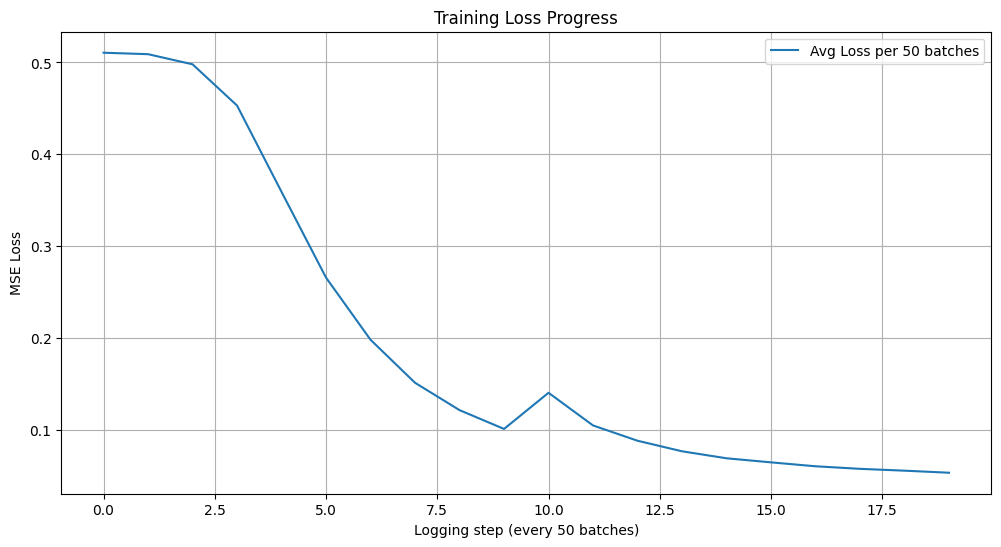

In [105]:
mf_model, user_labels, product_labels = train_matrix_factorization(
    train_df,
    latent_dim=1024,
    epochs=2,
    lr=0.001,
    batch_size=batch_size
)

In [ ]:
models_path = project_dir / 'models'
processed_data_path = project_dir / 'data' / 'processed'

In [ ]:
# # Сохраняем обученную MF-модель
# torch.save(mf_model.state_dict(), models_path / 'mf_model.pth')

# # Сохраняем user_labels и product_labels
# with open(processed_data_path / 'mf' / 'user_labels.pkl', 'wb') as f:
#     pickle.dump(user_labels, f)

# with open(processed_data_path / 'mf' / 'product_labels.pkl', 'wb') as f:
#     pickle.dump(product_labels, f)

In [108]:
# Загружаем user_labels и product_labels
with open(processed_data_path / 'mf' / 'user_labels.pkl', "rb") as f:
    user_labels = pickle.load(f)

with open(processed_data_path / 'mf' / 'product_labels.pkl', "rb") as f:
    product_labels = pickle.load(f)

# Воссоздаём архитектуру модели
num_users = len(user_labels)
num_items = len(product_labels)
latent_dim = 1024  # Указываем тот же размер, что был при обучении

mf_model = MatrixFactorization(num_users, num_items, latent_dim).to(device)

# Загружаем веса модели
mf_model.load_state_dict(torch.load(models_path / 'mf_model.pth'))

# Переводим модель в режим предсказания (инференса)
mf_model.eval()

MatrixFactorization(
  (user_factors): Embedding(242532, 1024)
  (item_factors): Embedding(269649, 1024)
)

In [135]:
# Получаем список тестовых пользователей
user_ids = test_df['anon_id_encrypred'].unique()

len(user_ids[:len(user_ids) // 50])

2859

In [136]:
# Получаем список тестовых пользователей
user_ids = test_df['anon_id_encrypred'].unique()

# Делаем рекомендации
user_recommendations_mf = recommend_mf_batch(
    user_ids=user_ids[:len(user_ids) // 50],
    model=mf_model,
    user_labels=user_labels,
    product_labels=product_labels,
    df=train_df,
    top_k_items=k,
    batch_size=8,
    filter_already_purchased=filter_already_purchased
)

Generating MF recommendations:   0%|          | 0/358 [00:00<?, ?it/s]

In [137]:
dataset_mf = RecommendationDataset(user_recommendations=user_recommendations_mf, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_mf, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

In [138]:
dataset_mf[0]

{'recs': tensor([13404705, 13404721, 12749132, 12883630,  2370888,  6869148]),
 'true': tensor([13588693, 13581910])}

In [139]:
len(dataset_mf)

2859

In [140]:
precision_k = precision_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Precision@k: {precision_k:.5f}')

recall_k = recall_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Recall@k: {recall_k:5f}')

map_k = map_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'MAP@k: {map_k:.5f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'NDCG@k: {ndcg_k:.5f}')

Precision@K:   0%|          | 0/3 [00:00<?, ?it/s]

Precision@k: 0.00023


Recall@K:   0%|          | 0/3 [00:00<?, ?it/s]

Recall@k: 0.000225


MAP@K:   0%|          | 0/3 [00:00<?, ?it/s]

MAP@k: 0.00004


NDCG@K:   0%|          | 0/3 [00:00<?, ?it/s]

NDCG@k: 0.00011


In [18]:
log_model_results(model_name='Matrix Factorization', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, 
                  hyperparameters={'top_k_items': k, 'latent_dim': latent_dim, 
                                   'filter_already_purchased': filter_already_purchased})
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Matrix Factorization,6,0.0011,0.001,0.001,0.0011,"{'top_k_items': 6, 'latent_dim': 256, 'filter_..."


In [24]:
df_ambassadors[df_ambassadors['anon_id_encrypred'].isin(user_ids[:len(user_ids) // 1000])]

0         True
1         True
2         True
3         True
4         True
         ...  
28997    False
28998    False
28999    False
29000    False
29001    False
Name: anon_id_encrypred, Length: 29002, dtype: bool

In [ ]:
train_user_to_true_items = train_df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()
test_user_to_true_items = test_df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()

In [43]:
def build_final_dataframe(df_group,  # df_ambassadors или df_rich
                          train_dict, test_dict,
                          rec_random, rec_topk, rec_ubcf, rec_ibcf, rec_mf,
                          n=10):
    """
    Формируем DataFrame по n пользователям из df_group, упорядочивая столбцы 
    в логике: ID, затем для каждой группы (train/test/random/etc):
      titles, brands, products, prices, links
    """
    all_keys = set(train_dict.keys()) | set(test_dict.keys()) \
               | set(rec_random.keys()) | set(rec_topk.keys()) \
               | set(rec_ubcf.keys())  | set(rec_ibcf.keys()) \
               | set(rec_mf.keys())
    
    # Выберем всех пользователей, кто есть и в df_group, и в all_keys
    df_ids = df_group['anon_id_encrypred'].unique()
    valid_ids = [uid for uid in df_ids if uid in all_keys]
    
    # Если таких больше n, берем первые n
    if len(valid_ids) > n:
        valid_ids = valid_ids[:n]
    
    rows = []
    for uid in valid_ids:
        # train
        train_items = list(train_dict.get(uid, []))
        train_links, train_prices, train_brands, train_titles = [], [], [], []
        for pid in train_items:
            link, price, br, tl = get_product_info(pid)
            train_links.append(link)
            train_prices.append(price)
            train_brands.append(br)
            train_titles.append(tl)
        
        # test
        test_items = list(test_dict.get(uid, []))
        test_links, test_prices, test_brands, test_titles = [], [], [], []
        for pid in test_items:
            link, price, br, tl = get_product_info(pid)
            test_links.append(link)
            test_prices.append(price)
            test_brands.append(br)
            test_titles.append(tl)
        
        # random
        random_items = list(rec_random.get(uid, []))
        random_links, random_prices, random_brands, random_titles = [], [], [], []
        for pid in random_items:
            link, price, br, tl = get_product_info(pid)
            random_links.append(link)
            random_prices.append(price)
            random_brands.append(br)
            random_titles.append(tl)
        
        # top_k
        topk_items = list(rec_topk.get(uid, []))
        topk_links, topk_prices, topk_brands, topk_titles = [], [], [], []
        for pid in topk_items:
            link, price, br, tl = get_product_info(pid)
            topk_links.append(link)
            topk_prices.append(price)
            topk_brands.append(br)
            topk_titles.append(tl)
        
        # ubcf
        ubcf_items = list(rec_ubcf.get(uid, []))
        ubcf_links, ubcf_prices, ubcf_brands, ubcf_titles = [], [], [], []
        for pid in ubcf_items:
            link, price, br, tl = get_product_info(pid)
            ubcf_links.append(link)
            ubcf_prices.append(price)
            ubcf_brands.append(br)
            ubcf_titles.append(tl)
        
        # ibcf
        ibcf_items = list(rec_ibcf.get(uid, []))
        ibcf_links, ibcf_prices, ibcf_brands, ibcf_titles = [], [], [], []
        for pid in ibcf_items:
            link, price, br, tl = get_product_info(pid)
            ibcf_links.append(link)
            ibcf_prices.append(price)
            ibcf_brands.append(br)
            ibcf_titles.append(tl)
        
        # mf
        mf_items = list(rec_mf.get(uid, []))
        mf_links, mf_prices, mf_brands, mf_titles = [], [], [], []
        for pid in mf_items:
            link, price, br, tl = get_product_info(pid)
            mf_links.append(link)
            mf_prices.append(price)
            mf_brands.append(br)
            mf_titles.append(tl)
        
        rows.append({
            'anon_id_encrypred': uid,
            # train
            'train_titles': train_titles,
            'train_brands': train_brands,
            'train_products': train_items,
            'train_prices': train_prices,
            'train_links': train_links,
            # test
            'test_titles': test_titles,
            'test_brands': test_brands,
            'test_products': test_items,
            'test_prices': test_prices,
            'test_links': test_links,
            # random
            'random_titles': random_titles,
            'random_brands': random_brands,
            'random_products': random_items,
            'random_prices': random_prices,
            'random_links': random_links,
            # top_k
            'top_k_titles': topk_titles,
            'top_k_brands': topk_brands,
            'top_k_products': topk_items,
            'top_k_prices': topk_prices,
            'top_k_links': topk_links,
            # ubcf
            'ubcf_titles': ubcf_titles,
            'ubcf_brands': ubcf_brands,
            'ubcf_products': ubcf_items,
            'ubcf_prices': ubcf_prices,
            'ubcf_links': ubcf_links,
            # ibcf
            'ibcf_titles': ibcf_titles,
            'ibcf_brands': ibcf_brands,
            'ibcf_products': ibcf_items,
            'ibcf_prices': ibcf_prices,
            'ibcf_links': ibcf_links,
            # mf
            'mf_titles': mf_titles,
            'mf_brands': mf_brands,
            'mf_products': mf_items,
            'mf_prices': mf_prices,
            'mf_links': mf_links,
        })
    
    df_res = pd.DataFrame(rows)
    
    # Явно указываем нужный порядок столбцов:
    desired_columns = [
        'anon_id_encrypred',
        # TRAIN
        'train_titles', 'train_brands', 'train_products', 'train_prices', 'train_links',
        # TEST
        'test_titles', 'test_brands', 'test_products', 'test_prices', 'test_links',
        # RANDOM
        'random_titles', 'random_brands', 'random_products', 'random_prices', 'random_links',
        # TOP-K
        'top_k_titles', 'top_k_brands', 'top_k_products', 'top_k_prices', 'top_k_links',
        # UBCF
        'ubcf_titles', 'ubcf_brands', 'ubcf_products', 'ubcf_prices', 'ubcf_links',
        # IBCF
        'ibcf_titles', 'ibcf_brands', 'ibcf_products', 'ibcf_prices', 'ibcf_links',
        # MF
        'mf_titles', 'mf_brands', 'mf_products', 'mf_prices', 'mf_links',
    ]
    # Переставляем колонки (на случай, если DataFrame имеет те же, но в другом порядке)
    df_res = df_res[desired_columns]
    return df_res


# ---------------------------------------------------------------
# 3. Пример использования
# ---------------------------------------------------------------
# 3.1 Собираем 10 строк для df_ambassadors
df_amb_10 = build_final_dataframe(
    df_group=df_ambassadors,
    train_dict=train_user_to_true_items,
    test_dict=test_user_to_true_items,
    rec_random=user_recommendations_random,
    rec_topk=user_recommendations_top_k,
    rec_ubcf=user_recommendations_ubcf,
    rec_ibcf=user_recommendations_ibcf,
    rec_mf=user_recommendations_mf,
    n=10
)

# 3.2 Собираем 10 строк для df_rich
df_rich_10 = build_final_dataframe(
    df_group=df_rich,
    train_dict=train_user_to_true_items,
    test_dict=test_user_to_true_items,
    rec_random=user_recommendations_random,
    rec_topk=user_recommendations_top_k,
    rec_ubcf=user_recommendations_ubcf,
    rec_ibcf=user_recommendations_ibcf,
    rec_mf=user_recommendations_mf,
    n=10
)

# Проверим результат
display(df_amb_10, df_rich_10)


,anon_id_encrypred,train_titles,train_brands,train_products,train_prices,train_links,test_titles,test_brands,test_products,test_prices,test_links,random_titles,random_brands,random_products,random_prices,random_links,top_k_titles,top_k_brands,top_k_products,top_k_prices,top_k_links,ubcf_titles,ubcf_brands,ubcf_products,ubcf_prices,ubcf_links,ibcf_titles,ibcf_brands,ibcf_products,ibcf_prices,ibcf_links,mf_titles,mf_brands,mf_products,mf_prices,mf_links
0,wyyypqqtpqppptqt,"[Хлопковое платье, Хлопковая рубашка, Хлопкова...","[HUGO, Paul & Shark, BOSS, BOSS, BOSS, Dolce&G...","[13601472, 13463459, 13439364, 13502218, 13642...","[16000.0, 16050.0, 5880.0, 3840.0, 1300.0, 211...",[https://st-cdn.tsum.com/sig/11f4789a902750d1f...,"[Шерстяной шарф, Хлопковая бейсболка, Галстук]","[BOSS, BOSS, BOSS]","[13610113, 13593083, 13491591]","[10500.0, 4700.0, 7995.0]","[None, https://st-cdn.tsum.com/sig/2aa0a05e8e7...","[Шелковый топ, Двусторонний ремень VLogo Signa...","[Proenza Schouler, Valentino, Versace Jeans Co...","[11102461, 12687611, 12993560, 13416324, 12062...","[15300.0, 49950.0, 33750.0, 28050.0, 38850.0, ...","[None, None, None, None, None, None]","[Комплект из двух боксеров, Комплект из двух б...","[Dolce&Gabbana, Dolce&Gabbana, Premiata, Dolce...","[13404705, 13404721, 2370888, 12749132, 128836...","[7760.0, 7760.0, 29050.0, 71700.0, 84500.0, 55...",[https://st-cdn.tsum.com/sig/c8fb07c6efaaa5178...,"[Комплект из двух пар носков, Хлопковая бейсбо...","[BOSS, Versace Jeans Couture, BOSS, BOSS, Duno...","[13456544, 13505484, 13576366, 13439367, 13415...","[2850.0, 7640.0, 5300.0, 5880.0, 82800.0, 7760.0]",[https://st-cdn.tsum.com/sig/7ef4612372897d7cc...,"[Юбка, Сумка Love One Classic, Хлопковый пулов...","[Blumarine, Pinko, Iro, Tom Ford, Giorgio Arma...","[13592319, 13608237, 13630851, 10657051, 13587...","[33950.0, 49700.0, 45650.0, 163500.0, 49500.0,...",[https://st-cdn.tsum.com/sig/c5d279d80679441b5...,"[Кожаные слипоны, Слитный купальник, Комбиниро...","[H`D`S`N Baracco, Scotch&Soda, Flower Mountain...","[12435815, 13332086, 13468168, 7594187, 134790...","[29950.0, 7550.0, 29600.0, 9360.0, 14600.0, 53...","[None, None, https://st-cdn.tsum.com/sig/f467e..."
1,wyyypqqtpqpppxwy,"[Куртка, Шерстяная кепка, Набор из 2-х стакано...","[Deha, Gucci, Baccarat, Dolce&Gabbana]","[13461536, 11247889, 13387866, 13430604]","[24100.0, 21650.0, 27500.0, 49950.0]","[None, None, None, None]","[Кардиган, Кольцо]","[Antonelli Firenze, Luv Aj]","[13324234, 13648375]","[52500.0, 8650.0]","[None, https://st-cdn.tsum.com/sig/ae306cf3ac7...","[Шелковый топ, Двусторонний ремень VLogo Signa...","[Proenza Schouler, Valentino, Versace Jeans Co...","[11102461, 12687611, 12993560, 13416324, 12062...","[15300.0, 49950.0, 33750.0, 28050.0, 38850.0, ...","[None, None, None, None, None, None]","[Комплект из двух боксеров, Комплект из двух б...","[Dolce&Gabbana, Dolce&Gabbana, Premiata, Dolce...","[13404705, 13404721, 2370888, 12749132, 128836...","[7760.0, 7760.0, 29050.0, 71700.0, 84500.0, 55...",[https://st-cdn.tsum.com/sig/c8fb07c6efaaa5178...,"[Панама, Клипсы, Бра-топ, Пуховик, Утепленный ...","[Gucci, Dolce&Gabbana, Dolce&Gabbana, Bacon, s...","[8034648, 13022889, 13416444, 13440544, 131624...","[22950.0, 42450.0, 21500.0, 125000.0, 82550.0,...","[None, https://st-cdn.tsum.com/sig/1797545d653...","[Шерстяная шапка, Платье, Шелковая блузка, Бар...","[Marni, Designer`s Cat, Designer`s Cat, Saint ...","[13436507, 12954264, 12968407, 8646903, 236264...","[16650.0, 20700.0, 13650.0, 299500.0, 3150.0, ...",[https://st-cdn.tsum.com/sig/67c651d5a424682d1...,"[Пододеяльник Links Embroidery, Хлопковые джог...","[Frette, Michael Kors, Tom Ford, Dolce&Gabbana...","[13382692, 12115746, 2541923, 13628355, 115680...","[96500.0, 18200.0, 207000.0, 123000.0, 133500....","[None, None, None, https://st-cdn.tsum.com/sig..."
2,wyyypqqtpqppqsyr,"[Льняная футболка, Кожаный ремень, Кожаные дер...","[120% Lino, Corneliani, Alexander McQueen, Dan...","[12691330, 13309189, 11824167

,anon_id_encrypred,train_titles,train_brands,train_products,train_prices,train_links,test_titles,test_brands,test_products,test_prices,test_links,random_titles,random_brands,random_products,random_prices,random_links,top_k_titles,top_k_brands,top_k_products,top_k_prices,top_k_links,ubcf_titles,ubcf_brands,ubcf_products,ubcf_prices,ubcf_links,ibcf_titles,ibcf_brands,ibcf_products,ibcf_prices,ibcf_links,mf_titles,mf_brands,mf_products,mf_prices,mf_links
0,wyyypqqtpqpprpws,"[Хлопковая футболка, Хлопковая футболка, Хлопк...","[Dolce&Gabbana, Dolce&Gabbana, Dolce&Gabbana, ...","[12803705, 12312995, 12311565, 10178895]","[59950.0, 29950.0, 55900.0, 27950.0]","[None, None, None, None]","[Серьги, Сумка Chain Hobo]","[Anton Heunis, J.W. Anderson]","[13549798, 13465383]","[13300.0, 123000.0]","[None, https://st-cdn.tsum.com/sig/912c78393e9...","[Шелковый топ, Двусторонний ремень VLogo Signa...","[Proenza Schouler, Valentino, Versace Jeans Co...","[11102461, 12687611, 12993560, 13416324, 12062...","[15300.0, 49950.0, 33750.0, 28050.0, 38850.0, ...","[None, None, None, None, None, None]","[Комплект из двух боксеров, Комплект из двух б...","[Dolce&Gabbana, Dolce&Gabbana, Premiata, Dolce...","[13404705, 13404721, 2370888, 12749132, 128836...","[7760.0, 7760.0, 29050.0, 71700.0, 84500.0, 55...",[https://st-cdn.tsum.com/sig/c8fb07c6efaaa5178...,"[Джинсы, Шелковая футболка, Замшевый бомбер, С...","[Kiton, Dolce&Gabbana, BOSS, Michael Kors, Off...","[11464250, 10897290, 13461154, 13089856, 13452...","[65400.0, 32250.0, 79100.0, 28880.0, 88950.0, ...","[None, None, https://st-cdn.tsum.com/sig/9bb1f...","[Шерстяная водолазка, Свитер из шерсти и кашем...","[Giorgio Armani, Giorgio Armani, Angulus, Palm...","[10396914, 11184534, 11730821, 13583284, 13456...","[78750.0, 44950.0, 8975.0, 23900.0, 18250.0, 1...","[None, https://st-cdn.tsum.com/sig/8be13a669d8...","[Солнцезащитные очки, Серьги, Кеды, Хлопковые ...","[Gucci, Anton Heunis, Missouri, Dolce&Gabbana,...","[13469357, 13615028, 12139483, 11314658, 13641...","[32500.0, 12500.0, 11750.0, 51650.0, 54950.0, ...",[https://st-cdn.tsum.com/sig/e7eee111a9e46de68...
1,wyyypqqtpqppupwq,"[Текстильные кеды VL7N, Джинсы, Хлопковая футб...","[Valentino, Kiton, Giorgio Armani, Zilli, Bott...","[12498177, 13370502, 13252105, 13294097, 11725...","[55100.0, 124500.0, 49700.0, 47300.0, 116000.0...","[None, https://st-cdn.tsum.com/sig/82b10436ab5...","[Хлопковая футболка, Хлопковая футболка, Хлопк...","[Giorgio Armani, Giorgio Armani, Zilli, Brunel...","[13252105, 13289913, 13294061, 13365689, 13211...","[49700.0, 49700.0, 63650.0, 99150.0, 68550.0, ...",[https://st-cdn.tsum.com/sig/50d175b34c6713e0f...,"[Шелковый топ, Двусторонний ремень VLogo Signa...","[Proenza Schouler, Valentino, Versace Jeans Co...","[11102461, 12687611, 12993560, 13416324, 12062...","[15300.0, 49950.0, 33750.0, 28050.0, 38850.0, ...","[None, None, None, None, None, None]","[Комплект из двух боксеров, Комплект из двух б...","[Dolce&Gabbana, Dolce&Gabbana, Premiata, Dolce...","[13404705, 13404721, 2370888, 12749132, 128836...","[7760.0, 7760.0, 29050.0, 71700.0, 84500.0, 55...",[https://st-cdn.tsum.com/sig/c8fb07c6efaaa5178...,"[Комбинированные кроссовки, Джинсы, Хлопковая ...","[Brioni, Dolce&Gabbana, Valentino, Valentino, ...","[10350256, 11209952, 11203779, 13377023, 13239...","[84250.0, 59950.0, 35950.0, 49300.0, 96800.0, ...","[None, https://st-cdn.tsum.com/sig/d381f04931c...","[Джинсы, Свитер из хлопка и льна, Юбка из хлоп...","[Brioni, Одежда Бутики\, Versace, Versace, Tom...","[10363695, 12452122, 12640620, 12513552, 11840...","[54200.0, 107500.0, 159000.0, 119500.0, 459500...","[None, None, https://st-cdn.tsum.com/sig/8d424...","[Сумка Crush, Плавки-шорты, Шерстяные брюки, Ш...","[Balenciaga, Givenchy, Marni, Kiton, N21, Prem...","[13561257, 13541634, 13438531, 11030978, 13504...","[312500.0, 17200.0, 84550.0, 89450.0, 33550.0,...","[None, None, None, None, https://st-cdn.tsum.c..."
2,wyyypqqtpqppuxuv,"[Замшевые лоферы, Джинсы, Хло

In [45]:
# Для df_ambassadors
df_amb_cols = list(df_ambassadors.columns)  # все столбцы исходника
df_amb_10_cols = [c for c in df_amb_10.columns if c not in df_amb_cols or c == 'anon_id_encrypred']
#  ^ оставим 'anon_id_encrypred', чтобы не пропал при мерже, 
#    а затем уберём дубликаты при переупорядочивании.

df_amb_merged = pd.merge(
    df_ambassadors, 
    df_amb_10, 
    how='left', 
    left_on='anon_id_encrypred', 
    right_on='anon_id_encrypred'
)

# Итоговый порядок: сначала все из df_ambassadors, затем всё остальное
df_amb_merged = df_amb_merged[df_amb_cols + [c for c in df_amb_10_cols if c != 'anon_id_encrypred']]

# Аналогично для df_rich
df_rich_cols = list(df_rich.columns)
df_rich_10_cols = [c for c in df_rich_10.columns if c not in df_rich_cols or c == 'anon_id_encrypred']

df_rich_merged = pd.merge(
    df_rich,
    df_rich_10,
    how='left',
    on='anon_id_encrypred'  # или left_on='anon_id_encrypred', right_on='anon_id_encrypred'
)

df_rich_merged = df_rich_merged[df_rich_cols + [c for c in df_rich_10_cols if c != 'anon_id_encrypred']]

# Проверим
display(df_amb_merged.head(5), df_rich_merged.head(5))

,anon_id_encrypred,total_receipts,avg_receipt_len,purchase_frequency,favourite_month_ratio,holiday_ratio,avg_receipt_value,avg_discount,premium_ratio,brand_entropy,category_entropy,collection_freshness,favourite_brand_ratio,train_titles,train_brands,train_products,train_prices,train_links,test_titles,test_brands,test_products,test_prices,test_links,random_titles,random_brands,random_products,random_prices,random_links,top_k_titles,top_k_brands,top_k_products,top_k_prices,top_k_links,ubcf_titles,ubcf_brands,ubcf_products,ubcf_prices,ubcf_links,ibcf_titles,ibcf_brands,ibcf_products,ibcf_prices,ibcf_links,mf_titles,mf_brands,mf_products,mf_prices,mf_links
0,wyyypqqtpqppptqt,8.0,1.500000,30.0,0.375000,0.625000,12986.739167,0.075913,0.0,1.357978,2.253858,91.5,0.500000,"[Хлопковое платье, Хлопковая рубашка, Хлопкова...","[HUGO, Paul & Shark, BOSS, BOSS, BOSS, Dolce&G...","[13601472, 13463459, 13439364, 13502218, 13642...","[16000.0, 16050.0, 5880.0, 3840.0, 1300.0, 211...",[https://st-cdn.tsum.com/sig/11f4789a902750d1f...,"[Шерстяной шарф, Хлопковая бейсболка, Галстук]","[BOSS, BOSS, BOSS]","[13610113, 13593083, 13491591]","[10500.0, 4700.0, 7995.0]","[None, https://st-cdn.tsum.com/sig/2aa0a05e8e7...","[Шелковый топ, Двусторонний ремень VLogo Signa...","[Proenza Schouler, Valentino, Versace Jeans Co...","[11102461, 12687611, 12993560, 13416324, 12062...","[15300.0, 49950.0, 33750.0, 28050.0, 38850.0, ...","[None, None, None, None, None, None]","[Комплект из двух боксеров, Комплект из двух б...","[Dolce&Gabbana, Dolce&Gabbana, Premiata, Dolce...","[13404705, 13404721, 2370888, 12749132, 128836...","[7760.0, 7760.0, 29050.0, 71700.0, 84500.0, 55...",[https://st-cdn.tsum.com/sig/c8fb07c6efaaa5178...,"[Комплект из двух пар носков, Хлопковая бейсбо...","[BOSS, Versace Jeans Couture, BOSS, BOSS, Duno...","[13456544, 13505484, 13576366, 13439367, 13415...","[2850.0, 7640.0, 5300.0, 5880.0, 82800.0, 7760.0]",[https://st-cdn.tsum.com/sig/7ef4612372897d7cc...,"[Юбка, Сумка Love One Classic, Хлопковый пулов...","[Blumarine, Pinko, Iro, Tom Ford, Giorgio Arma...","[13592319, 13608237, 13630851, 10657051, 13587...","[33950.0, 49700.0, 45650.0, 163500.0, 49500.0,...",[https://st-cdn.tsum.com/sig/c5d279d80679441b5...,"[Кожаные слипоны, Слитный купальник, Комбиниро...","[H`D`S`N Baracco, Scotch&Soda, Flower Mountain...","[12435815, 13332086, 13468168, 7594187, 134790...","[29950.0, 7550.0, 29600.0, 9360.0, 14600.0, 53...","[None, None, https://st-cdn.tsum.com/sig/f467e..."
1,wyyypqqtpqpppxwy,5.0,1.200000,83.0,0.400000,0.600000,19891.528000,0.265073,0.0,1.791759,1.791759,22.0,0.166667,"[Куртка, Шерстяная кепка, Набор из 2-х стакано...","[Deha, Gucci, Baccarat, Dolce&Gabbana]","[13461536, 11247889, 13387866, 13430604]","[24100.0, 21650.0, 27500.0, 49950.0]","[None, None, None, None]","[Кардиган, Кольцо]","[Antonelli Firenze, Luv Aj]","[13324234, 13648375]","[52500.0, 8650.0]","[None, https://st-cdn.tsum.com/sig/ae306cf3ac7...","[Шелковый топ, Двусторонний ремень VLogo Signa...","[Proenza Schouler, Valentino, Versace Jeans Co...","[11102461, 12687611, 12993560, 13416324, 12062...","[15300.0, 49950.0, 33750.0, 28050.0, 38850.0, ...","[None, None, None, None, None, None]","[Комплект из двух боксеров, Комплект из двух б...","[Dolce&Gabbana, Dolce&Gabbana, Premiata, Dolce...","[13404705, 13404721, 2370888, 12749132, 128836...","[7760.0, 7760.0, 29050.0, 71700.0, 84500.0, 55...",[https://st-cdn.tsum.com/sig/c8fb07c6efaaa5178...,"[Панама, Клипсы, Бра-топ, Пуховик, Утепленный ...","[Gucci, Dolce&Gabbana, Dolce&Gabbana, Bacon, s...","[8034648, 13022889, 13416444, 13440544, 131624...","[22950.0, 42450.0, 21500.0, 125000.0, 82550.0,...","[None, https://st-cdn.tsum.com/sig/1797545d653...","[Шерстяная шапка, Платье, Шелковая блузка, Бар...","[Marni, Designer`s Cat, Designer`s Cat, Saint ...","[13436507, 12954264, 12968407, 8646903, 236264...","[16650.0, 20700.0, 13650.0, 299500.0, 3150.0, ...",[https://st-cdn.tsum.com/sig/67c651d5a424682d1...,"[Пододеяльник Links

,anon_id_encrypred,total_receipts,avg_receipt_len,purchase_frequency,favourite_month_ratio,holiday_ratio,avg_receipt_value,avg_discount,premium_ratio,brand_entropy,category_entropy,collection_freshness,favourite_brand_ratio,train_titles,train_brands,train_products,train_prices,train_links,test_titles,test_brands,test_products,test_prices,test_links,random_titles,random_brands,random_products,random_prices,random_links,top_k_titles,top_k_brands,top_k_products,top_k_prices,top_k_links,ubcf_titles,ubcf_brands,ubcf_products,ubcf_prices,ubcf_links,ibcf_titles,ibcf_brands,ibcf_products,ibcf_prices,ibcf_links,mf_titles,mf_brands,mf_products,mf_prices,mf_links
0,wyyypqqtpqpprpws,5.0,1.200000,177.5,0.400000,0.80000,42149.544000,0.217372,0.166667,1.242453,1.560710,384.0,0.500000,"[Хлопковая футболка, Хлопковая футболка, Хлопк...","[Dolce&Gabbana, Dolce&Gabbana, Dolce&Gabbana, ...","[12803705, 12312995, 12311565, 10178895]","[59950.0, 29950.0, 55900.0, 27950.0]","[None, None, None, None]","[Серьги, Сумка Chain Hobo]","[Anton Heunis, J.W. Anderson]","[13549798, 13465383]","[13300.0, 123000.0]","[None, https://st-cdn.tsum.com/sig/912c78393e9...","[Шелковый топ, Двусторонний ремень VLogo Signa...","[Proenza Schouler, Valentino, Versace Jeans Co...","[11102461, 12687611, 12993560, 13416324, 12062...","[15300.0, 49950.0, 33750.0, 28050.0, 38850.0, ...","[None, None, None, None, None, None]","[Комплект из двух боксеров, Комплект из двух б...","[Dolce&Gabbana, Dolce&Gabbana, Premiata, Dolce...","[13404705, 13404721, 2370888, 12749132, 128836...","[7760.0, 7760.0, 29050.0, 71700.0, 84500.0, 55...",[https://st-cdn.tsum.com/sig/c8fb07c6efaaa5178...,"[Джинсы, Шелковая футболка, Замшевый бомбер, С...","[Kiton, Dolce&Gabbana, BOSS, Michael Kors, Off...","[11464250, 10897290, 13461154, 13089856, 13452...","[65400.0, 32250.0, 79100.0, 28880.0, 88950.0, ...","[None, None, https://st-cdn.tsum.com/sig/9bb1f...","[Шерстяная водолазка, Свитер из шерсти и кашем...","[Giorgio Armani, Giorgio Armani, Angulus, Palm...","[10396914, 11184534, 11730821, 13583284, 13456...","[78750.0, 44950.0, 8975.0, 23900.0, 18250.0, 1...","[None, https://st-cdn.tsum.com/sig/8be13a669d8...","[Солнцезащитные очки, Серьги, Кеды, Хлопковые ...","[Gucci, Anton Heunis, Missouri, Dolce&Gabbana,...","[13469357, 13615028, 12139483, 11314658, 13641...","[32500.0, 12500.0, 11750.0, 51650.0, 54950.0, ...",[https://st-cdn.tsum.com/sig/e7eee111a9e46de68...
1,wyyypqqtpqppupwq,7.0,4.142857,5.5,0.571429,0.00000,67846.828231,0.089116,0.206897,1.924485,1.627668,111.0,0.275862,"[Текстильные кеды VL7N, Джинсы, Хлопковая футб...","[Valentino, Kiton, Giorgio Armani, Zilli, Bott...","[12498177, 13370502, 13252105, 13294097, 11725...","[55100.0, 124500.0, 49700.0, 47300.0, 116000.0...","[None, https://st-cdn.tsum.com/sig/82b10436ab5...","[Хлопковая футболка, Хлопковая футболка, Хлопк...","[Giorgio Armani, Giorgio Armani, Zilli, Brunel...","[13252105, 13289913, 13294061, 13365689, 13211...","[49700.0, 49700.0, 63650.0, 99150.0, 68550.0, ...",[https://st-cdn.tsum.com/sig/50d175b34c6713e0f...,"[Шелковый топ, Двусторонний ремень VLogo Signa...","[Proenza Schouler, Valentino, Versace Jeans Co...","[11102461, 12687611, 12993560, 13416324, 12062...","[15300.0, 49950.0, 33750.0, 28050.0, 38850.0, ...","[None, None, None, None, None, None]","[Комплект из двух боксеров, Комплект из двух б...","[Dolce&Gabbana, Dolce&Gabbana, Premiata, Dolce...","[13404705, 13404721, 2370888, 12749132, 128836...","[7760.0, 7760.0, 29050.0, 71700.0, 84500.0, 55...",[https://st-cdn.tsum.com/sig/c8fb07c6efaaa5178...,"[Комбинированные кроссовки, Джинсы, Хлопковая ...","[Brioni, Dolce&Gabbana, Valentino, Valentino, ...","[10350256, 11209952, 11203779, 13377023, 13239...","[84250.0, 59950.0, 35950.0, 49300.0, 96800.0, ...","[None, https://st-cdn.tsum.com/sig/d381f04931c...","[Джинсы, Свитер из хлопка и льна, Юбка из хлоп...","[Brioni, Одежда Бутики\, Versace, Versace, Tom...","[10363695, 12452122, 12640620, 12513552, 11840...","[54200.0,

In [48]:
df_amb_merged.dropna().to_excel("final_ambassadors.xlsx", index=False)
df_rich_merged.dropna().to_excel("final_rich.xlsx", index=False)

In [79]:
# k = 5 # top_k_items
# n = 100 # n_components

# # Функция подготовки user-item матрицы с логарифмом
# def prepare_user_item_matrix(df):
#     """
#     Создает user-item матрицу с логарифмом количества покупок.
    
#     df: DataFrame с колонками ['anon_id_encrypred', 'product_id', 'base_price']
    
#     Возвращает:
#     - user_item_matrix (numpy 2D массив)
#     - users_mapping (словарь user_id -> индекс)
#     - items_mapping (словарь product_id -> индекс)
#     - reverse_users_mapping (словарь индекс -> user_id)
#     - reverse_items_mapping (словарь индекс -> product_id)
#     """
#     df = df.copy()
#     df['log_purchases'] = df.groupby(['anon_id_encrypred', 'product_id'])['base_price'].transform('count')
#     df['log_purchases'] = np.log1p(df['log_purchases'])  # log(1 + count)

#     # Уникальные пользователи и товары
#     users = df['anon_id_encrypred'].unique()
#     items = df['product_id'].unique()
    
#     # Создаем маппинги ID → индекс
#     users_mapping = {user: i for i, user in enumerate(users)}
#     items_mapping = {item: i for i, item in enumerate(items)}
    
#     # Обратные маппинги индекс → ID
#     reverse_users_mapping = {i: user for user, i in users_mapping.items()}
#     reverse_items_mapping = {i: item for item, i in items_mapping.items()}

#     # Создаем user-item матрицу
#     user_item_matrix = np.zeros((len(users), len(items)))
#     for _, row in df.iterrows():
#         user_idx = users_mapping[row['anon_id_encrypred']]
#         item_idx = items_mapping[row['product_id']]
#         user_item_matrix[user_idx, item_idx] = row['log_purchases']
    
#     return user_item_matrix, users_mapping, items_mapping, reverse_users_mapping, reverse_items_mapping

# # Функция вычисления SVD
# def compute_svd(user_item_matrix, n_components=n):
#     """
#     Вычисляет SVD-разложение user-item матрицы.
    
#     user_item_matrix: numpy 2D массив (пользователи x товары)
#     n_components: Количество скрытых факторов
    
#     Возвращает:
#     - предсказанную user-item матрицу (numpy 2D массив)
#     """
#     # Выполняем SVD
#     U, sigma, Vt = svds(user_item_matrix, k=n_components)
    
#     # Преобразуем sigma (диагональную) в квадратную матрицу
#     sigma = np.diag(sigma)

#     # Восстанавливаем предсказанную матрицу рейтингов R = U * Σ * V^T
#     predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    
#     return predicted_ratings

# # Функция рекомендаций
# def recommend_svd(user_id, predicted_matrix, users_mapping, items_mapping, reverse_items_mapping, top_k_items=k):
#     """
#     Для пользователя user_id предсказываем top-K товаров на основе предсказанной матрицы.
#     """
#     if user_id not in users_mapping:
#         return []
    
#     user_idx = users_mapping[user_id]
#     predicted_scores = predicted_matrix[user_idx]
#     top_item_indices = np.argsort(predicted_scores)[::-1][:top_k_items]
#     recommended_items = [reverse_items_mapping[i] for i in top_item_indices]
    
#     return recommended_items

# # Запуск модели
# user_item_matrix, users_mapping, items_mapping, reverse_users_mapping, reverse_items_mapping = prepare_user_item_matrix(train_df)
# predicted_ratings = compute_svd(user_item_matrix, n_components=n)


# user_recommendations_svd = {user: recommend_svd(user, predicted_ratings, users_mapping, items_mapping, reverse_items_mapping, top_k_items=k) 
#                             for user in tqdm(test_df['anon_id_encrypred'].unique())}

  0%|          | 0/4203 [00:00<?, ?it/s]

In [80]:
precision_k = precision_at_k(user_recommendations=user_recommendations_svd, eval_df=test_df, k=k)
recall_k = recall_at_k(user_recommendations=user_recommendations_svd, eval_df=test_df, k=k)
map_k = map_at_k(user_recommendations=user_recommendations_svd, eval_df=test_df, k=k)
ndcg_k = ndcg_at_k(user_recommendations=user_recommendations_svd, eval_df=test_df, k=k)

print(f'Precision@k: {precision_k:.5f}')
print(f'Recall@k: {recall_k:5f}')
print(f'MAP@k: {map_k:.5f}')
print(f'NDCG@k: {ndcg_k:.5f}')

Precision@k: 0.00427
Recall@k: 0.002171
MAP@k: 0.30818
NDCG@k: 0.00412


In [81]:
log_model_results(model_name='SVD', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, 
                  hyperparameters={'top_k_items': k, 'n_components': n})
df_metrics

,Model,k,Precision@k,Recall@k,MAP@k,NDCG@k,Other_hyperparameters
0,Top-K,5,0.00138,0.00057,0.20033,0.00161,None
1,Random,5,0.00000,0.00000,NaN,0.00000,None
2,UBCF,5,0.01055,0.00670,0.26343,0.01020,"{'top_k_items': 5, 'top_n_similar_users': 20}"
3,IBCF,5,0.00458,0.00573,0.24515,0.00570,"{'top_k_items': 5, 'top_n_similar_items': 20}"
4,SVD,5,0.00175,0.00090,0.39059,0.00198,"{'top_k_items': 5, 'n_components': 20}"
5,SVD,5,0.00427,0.00217,0.30818,0.00412,"{'top_k_items': 5, 'n_components': 100}"


## Strong Models

### BERT4Rec самописный

In [1]:
# Базовые импорты
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
from pathlib import Path
import random
from collections import Counter, defaultdict
import itertools
import random
# from datetime import datetime
from tqdm.auto import tqdm
from IPython.display import display
import matplotlib.pyplot as plt

# Импорты для RecSys
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
# from surprise import SVD, Dataset, Reader

import torch
import torch.nn as nn
import pickle
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.mps.set_per_process_memory_fraction(0.95)  # Ограничение памяти до 80%
# torch.mps.empty_cache()

# Метрики
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

In [2]:
# class BERT4RecDataset(Dataset):
#     def __init__(self, 
#                  sequences, 
#                  max_len, 
#                  mask_prob, 
#                  num_items, 
#                  pad_token=0, 
#                  mask_token=None):
#         """
#         Инициализация датасета
        
#         :param sequences: Список последовательностей взаимодействий
#         :param max_len: Максимальная длина последовательности
#         :param mask_prob: Вероятность маскирования элемента
#         :param num_items: Количество уникальных элементов в датасете
#         :param pad_token: Токен для дополнения последовательностей
#         :param mask_token: Токен для маскирования элементов
#         """
#         self.sequences = sequences
#         self.max_len = max_len
#         self.mask_prob = mask_prob
#         self.num_items = num_items
#         self.pad_token = pad_token
#         self.mask_token = mask_token if mask_token is not None else num_items + 1

#         # Предобработка последовательностей
#         self.processed_sequences = []
#         for seq in sequences:
#             # Обрезка последовательности (берём последние покупки, поэтому -self.max_len)
#             truncated = seq[-self.max_len:] if len(seq) > self.max_len else seq
#             # Дополнение до максимальной длины
#             padded = [self.pad_token] * (self.max_len - len(truncated)) + truncated
#             self.processed_sequences.append(padded)

#     def __len__(self):
#         return len(self.processed_sequences)

#     def __getitem__(self, idx):
#         seq = self.processed_sequences[idx].copy()
#         input_seq = []
#         target_seq = []
        
#         for item in seq:
#             if item == self.pad_token:
#                 # Для pad-токенов не применяем маскирование
#                 input_seq.append(self.pad_token)
#                 target_seq.append(0)  # Игнорируется в функции потерь
#                 continue
#             # mask_prob_modern = self.mask_prob if len(seq) > 1 else 1.0  # Всегда маскируем одиночные токены
#             # if random.random() < mask_prob_modern:
#             if random.random() < self.mask_prob:
#                 # Стратегия маскирования как в оригинальном BERT
#                 rand_prob = random.random()
#                 if rand_prob < 0.8:
#                     # Замена на маску
#                     input_seq.append(self.mask_token)
#                 elif rand_prob < 0.9:
#                     # Замена на случайный элемент
#                     input_seq.append(random.randint(1, self.num_items))
#                 else:
#                     # Оставить оригинальный элемент
#                     input_seq.append(item)
#                 target_seq.append(item)
#             else:
#                 input_seq.append(item)
#                 target_seq.append(0)  # Не маскированные элементы игнорируются

#         # Создаем маску внимания
#         attention_mask = [1 if token != self.pad_token else 0 for token in seq]
#         # Позиционные индексы
#         position_ids = torch.arange(self.max_len, dtype=torch.long)

#         return {
#             "input_ids": torch.tensor(input_seq, dtype=torch.long),
#             "labels": torch.tensor(target_seq, dtype=torch.long),
#             "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
#             "position_ids": position_ids  # Добавляем позиционные индексы
#         }

In [3]:
class BERT4RecDataset(Dataset):
    def __init__(self, 
                 sequences, 
                 max_len, 
                 mask_prob, 
                 num_items, 
                 pad_token=0, 
                 mask_token=None, 
                 is_train=True):
        """
        Датасет для BERT4Rec.

        :param sequences: Список кортежей (user_id, sequence)
        :param max_len: Максимальная длина последовательности
        :param mask_prob: Вероятность маскирования элемента (только для train)
        :param num_items: Количество уникальных элементов в датасете
        :param pad_token: Токен для дополнения последовательностей
        :param mask_token: Токен для маскирования элементов
        :param is_train: Использовать ли маскирование (True — обучение, False — тест/валидация)
        """
        self.max_len = max_len
        self.mask_prob = mask_prob
        self.num_items = num_items
        self.pad_token = pad_token
        self.mask_token = mask_token if mask_token is not None else num_items + 1
        self.is_train = is_train 

        self.user_ids = []
        self.processed_sequences = []
        
        for user_id, seq in sequences:
            self.user_ids.append(user_id)
            truncated = seq[-self.max_len:] if len(seq) > self.max_len else seq
            padded = [self.pad_token] * (self.max_len - len(truncated)) + truncated
            self.processed_sequences.append(padded)

    def __len__(self):
        return len(self.processed_sequences)

    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        seq = self.processed_sequences[idx].copy()
        
        input_seq = []
        target_seq = []
        
        for item in seq:
            if item == self.pad_token:
                input_seq.append(self.pad_token)
                target_seq.append(0)  # Игнорируется в функции потерь
                continue

            if self.is_train and random.random() < self.mask_prob:  # <-- Маскируем только в train
                rand_prob = random.random()
                if rand_prob < 0.8:
                    input_seq.append(self.mask_token)  # Маскируем
                elif rand_prob < 0.9:
                    input_seq.append(random.randint(1, self.num_items))  # Рандомный токен
                else:
                    input_seq.append(item)  # Оставляем
                target_seq.append(item)
            else:
                input_seq.append(item)
                target_seq.append(0)  # Не маскированные элементы игнорируются

        attention_mask = [1 if token != self.pad_token else 0 for token in seq]
        position_ids = torch.arange(self.max_len, dtype=torch.long)

        return {
            "user_id": user_id,
            "input_ids": torch.tensor(input_seq, dtype=torch.long),
            "labels": torch.tensor(target_seq, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "position_ids": position_ids
        }

In [7]:
notebook_path = Path().resolve()
project_dir = notebook_path.parent

interim_data_path = project_dir / 'data' / 'interim'

# df_filtered = pd.read_csv(interim_data_path / 'df_filtered.csv')
# df_filtered['order_date'] = pd.to_datetime(df_filtered['order_date'])
# df_filtered = df_filtered.sort_values(by=['anon_id_encrypred', 'order_date'])

# # Создаем маппинг оригинальных product_id в новые индексы от 1 до df_filtered['product_id'].unique()
# unique_product_ids = df_filtered['product_id'].unique()
# product_id_to_idx = {product_id: idx + 1 for idx, product_id in enumerate(unique_product_ids)}  # +1 чтобы начинать с 1

# # Применяем маппинг к данным
# df_filtered['product_idx'] = df_filtered['product_id'].map(product_id_to_idx)

# threshold_level = 0.8
# min_date = df_filtered['order_date'].min()
# max_date = df_filtered['order_date'].max()

# print(f"Min date: {min_date}")
# print(f"Max date: {max_date}")

# total_days = (max_date - min_date).days
# threshold_days = int(total_days * threshold_level)
# threshold_date = min_date + pd.Timedelta(days=threshold_days)

# print(f"Threshold date ({round(threshold_level * 100, 0)}%): {threshold_date}")

# train_df = df_filtered[df_filtered['order_date'] < threshold_date]
# test_df = df_filtered[df_filtered['order_date'] >= threshold_date]

# interim_data_path = project_dir / 'data' / 'interim'
# df_filtered.to_csv(interim_data_path / 'df_filtered_for_bert4rec.csv', index=False)
# train_df.to_csv(interim_data_path / 'train_data_by_threshold_date_for_bert4rec.csv', index=False)
# test_df.to_csv(interim_data_path / 'test_data_by_threshold_date_for_bert4rec.csv', index=False)

df_filtered = pd.read_csv(interim_data_path / 'df_filtered_for_bert4rec.csv')
train_df = pd.read_csv(interim_data_path / 'train_data_by_threshold_date_for_bert4rec.csv')
test_df = pd.read_csv(interim_data_path / 'test_data_by_threshold_date_for_bert4rec.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


# test_user_to_true_items = test_df.groupby('anon_id_encrypred')['product_id'].apply(set).to_dict()

print("Минимальный новый индекс:", df_filtered['product_idx'].min())  # Должно быть 1
print("Максимальный новый индекс:", df_filtered['product_idx'].max())  # Должно быть равно количеству уникальных товаров
print("Количество уникальных товаров:", df_filtered['product_id'].nunique())
print(f"Всего пользователей: {len(df_filtered['anon_id_encrypred'].unique())}")
print(f"Пользователей в тренировочной выборке: {len(train_df['anon_id_encrypred'].unique())}")
print(f"Пользователей в тестовой выборке: {len(test_df['anon_id_encrypred'].unique())}")

Train shape: (2526624, 21)
Test shape: (704478, 21)
Минимальный новый индекс: 1
Максимальный новый индекс: 309343
Количество уникальных товаров: 309343
Всего пользователей: 273287
Пользователей в тренировочной выборке: 242532
Пользователей в тестовой выборке: 142987


In [8]:
# Группируем по пользователям и считаем длину последовательности для каждого
user_sequence_lengths = df_filtered.groupby('anon_id_encrypred').size()
percentiles = user_sequence_lengths.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
# Находим максимальную длину последовательности
max_sequence_length = user_sequence_lengths.max()
print("Перцентили длин последовательностей:")
print(percentiles)
print(f"Максимальная длина последовательности: {max_sequence_length}")

Перцентили длин последовательностей:
0.25      2.0
0.50      4.0
0.75     11.0
0.90     26.0
0.95     45.0
0.99    116.0
dtype: float64
Максимальная длина последовательности: 1014


In [9]:
# Создаём последовательности покупок для каждого пользователя
train_sequences = train_df.groupby('anon_id_encrypred')['product_idx'].apply(list).to_dict()
test_sequences = test_df.groupby('anon_id_encrypred')['product_idx'].apply(list).to_dict()

# Проверяем пример последовательности для одного пользователя
print(f"Пример последовательности для пользователя {list(train_sequences.keys())[1]}: {train_sequences[list(train_sequences.keys())[1]]}")

Пример последовательности для пользователя qqwuysvt: [6, 7, 8, 9, 7, 10]


In [10]:
# Параметры датасета
max_len = 12          # Максимальная длина последовательности
mask_prob = 0.2       # Вероятность маскирования
num_items = df_filtered['product_idx'].nunique()  # Количество уникальных товаров

# Преобразуем словари последовательностей в списки кортежей (user_id, sequence)
train_sequences_list = list(train_sequences.items())
test_sequences_list = list(test_sequences.items())

# Создаем датасеты
train_dataset = BERT4RecDataset(
    sequences=train_sequences_list,
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=True
)

test_dataset = BERT4RecDataset(
    sequences=test_sequences_list,
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=False
)

# Создаем DataLoader для тренировочного и тестового датасетов
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Пример использования DataLoader
for batch in train_loader:
    user_ids = batch['user_id'][0]
    input_ids = batch['input_ids'][0]
    labels = batch['labels'][0]
    attention_mask = batch['attention_mask'][0]
    position_ids = batch['position_ids'][0]
    
    print("User ID:", user_ids)
    print("Input IDs:", input_ids)
    print("Labels:", labels)
    print("Attention Mask:", attention_mask)
    print("Position IDs:", position_ids)
    break  # Остановимся после первого батча для примера

User ID: wyyypqqtprspstrs
Input IDs: tensor([     0,      0,      0,      0,      0,      0,      0,      0,      0,
         44837,  81049, 309344])
Labels: tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 2557])
Attention Mask: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])
Position IDs: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])


In [11]:
class BERT4RecModel(nn.Module):
    def __init__(self, num_items, max_len, embedding_dim=512, num_layers=6, num_heads=8, 
                 dropout=0.1, ffn_dim=2048):
        super().__init__()
        self.num_items = num_items
        self.max_len = max_len
        
        # Token Embeddings (+2 для pad и mask токенов)
        self.item_embeddings = nn.Embedding(num_items + 2, embedding_dim, padding_idx=0)
        
        # Позиционные энкодинги с LayerNorm
        self.position_embeddings = nn.Embedding(max_len, embedding_dim)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Трансформерный энкодер с улучшенными параметрами
        encoder_layers = TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Расширенная классифицирующая голова
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim*2),
            nn.GELU(),
            nn.LayerNorm(embedding_dim*2),
            nn.Linear(embedding_dim*2, num_items + 1)
        )
        
        # Инициализация весов
        self._init_weights()

    def _init_weights(self):
        """Инициализация весов как в оригинальном BERT"""
        # Инициализация эмбеддингов
        nn.init.normal_(self.item_embeddings.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.position_embeddings.weight, mean=0.0, std=0.02)
        
        # Инициализация слоев трансформера
        for layer in self.transformer.layers:
            nn.init.xavier_uniform_(layer.self_attn.in_proj_weight)
            nn.init.xavier_uniform_(layer.self_attn.out_proj.weight)
            nn.init.xavier_uniform_(layer.linear1.weight)
            nn.init.xavier_uniform_(layer.linear2.weight)
            
        # Инициализация классификатора
        nn.init.xavier_uniform_(self.fc[0].weight)
        nn.init.xavier_uniform_(self.fc[3].weight)

    def forward(self, input_ids, attention_mask, position_ids):
        # Эмбеддинги токенов
        item_embeds = self.item_embeddings(input_ids)
        
        # Позиционные энкодинги
        pos_embeds = self.position_embeddings(position_ids)
        
        # Комбинирование с нормализацией и дропаутом
        embeddings = self.layer_norm(item_embeds + pos_embeds)
        embeddings = self.dropout(embeddings)
        
        # Создаем ключевую маску для трансформера
        src_key_padding_mask = (attention_mask == 0)
        
        # Пропускаем через трансформер
        transformer_output = self.transformer(
            embeddings,
            src_key_padding_mask=src_key_padding_mask
        )
        
        # Классификация
        logits = self.fc(transformer_output)
        return logits

In [12]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=5,
    log_interval=50,  # Логировать каждые 50 батчей
    save_path="best_model.pth",
):
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0) # игнорим паддинги и добавляем стохастики label_smoothing=0.1
    best_loss = float('inf')
    
    # Для визуализации
    train_loss_history = []
    val_loss_history = []
    batch_counter = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        progress_bar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Training, Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, batch in progress_bar_train:
            # Перенос данных на устройство
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            position_ids = batch['position_ids'].to(device)
            
            # Forward и backward pass
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, position_ids)
            loss = criterion(outputs.view(-1, outputs.size(-1)), 
                            labels.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Логирование
            running_loss += loss.item()
            if (batch_idx + 1) % log_interval == 0:
                avg_loss = running_loss / log_interval
                train_loss_history.append(avg_loss)
                running_loss = 0.0
                batch_counter += 1
            
            progress_bar_train.set_postfix(loss=loss.item())

        # # Validation после эпохи
        # model.eval()
        # val_loss = 0.0
        # progress_bar_val = tqdm(val_loader,  total=len(val_loader), desc=f'Validation, Epoch {epoch+1}/{num_epochs}')
        
        # with torch.no_grad():
        #     for batch in progress_bar_val:
        #         input_ids = batch['input_ids'].to(device)
        #         labels = batch['labels'].to(device)
        #         attention_mask = batch['attention_mask'].to(device)
        #         position_ids = batch['position_ids'].to(device)
                
        #         outputs = model(input_ids, attention_mask, position_ids)
        #         loss = criterion(outputs.view(-1, outputs.size(-1)), 
        #                         labels.view(-1))
        #         val_loss += loss.item()
                
        #         # Обновляем прогресс-бар с текущим лоссом
        #         progress_bar_val.set_postfix(val_loss=loss.item())
        
        # avg_val_loss = val_loss / len(val_loader)
        # val_loss_history.append(avg_val_loss)
        
        # # Сохранение лучшей модели
        # if avg_val_loss < best_loss:
        #     best_loss = avg_val_loss
        #     torch.save(model.state_dict(), save_path)
        #     print(f"New best model saved with val loss: {best_loss:.4f}")
    
    return train_loss_history, val_loss_history

In [13]:
model = BERT4RecModel(
    num_items=num_items,
    max_len=max_len,
    embedding_dim=256, # было 256
    num_layers=3,       # Кол-во атеншн слоёв (Аттеншн + лин + нелин + дропаут)
    num_heads=4,        # Головы аттеншн слоёв
    dropout=0.01 # было 0.1
).to(device)


optimizer = torch.optim.AdamW(model.parameters(), 
                             lr=1e-5, # Было 1e-4
                             weight_decay=0.01)

In [14]:
model

BERT4RecModel(
  (item_embeddings): Embedding(309345, 256, padding_idx=0)
  (position_embeddings): Embedding(12, 256)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.01, inplace=False)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=2048, bias=True)
        (dropout): Dropout(p=0.01, inplace=False)
        (linear2): Linear(in_features=2048, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.01, inplace=False)
        (dropout2): Dropout(p=0.01, inplace=False)
      )
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=256, o

In [15]:
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=5,
    log_interval=100,
    save_path="bert4rec_best.pth"
)

Training, Epoch 1/5:   0%|          | 0/3790 [00:00<?, ?it/s]

Training, Epoch 2/5:   0%|          | 0/3790 [00:00<?, ?it/s]

Training, Epoch 3/5:   0%|          | 0/3790 [00:00<?, ?it/s]

Training, Epoch 4/5:   0%|          | 0/3790 [00:00<?, ?it/s]

Training, Epoch 5/5:   0%|          | 0/3790 [00:00<?, ?it/s]

In [45]:
# from torch_lr_finder import TrainDataLoaderIter

# criterion = torch.nn.CrossEntropyLoss(ignore_index=0) # игнорим паддинги

# optimizer = torch.optim.AdamW(model.parameters(), 
#                              # lr=1e-5, # Было 1e-4
#                              weight_decay=0.01)

# class CustomTrainDataLoaderIter(TrainDataLoaderIter):
#     def inputs_labels_from_batch(self, batch_data):
#         # Извлекаем данные из батча
#         inputs = {
#             'input_ids': batch_data['input_ids'],          # Input IDs
#             'attention_mask': batch_data['attention_mask'], # Attention Mask
#             'position_ids': batch_data['position_ids']     # Position IDs
#         }
#         labels = batch_data['labels']  # Labels
#         return inputs, labels


# # Создаем кастомный итератор
# train_iter = CustomTrainDataLoaderIter(train_loader)

# # Инициализация LRFinder
# lr_finder = LRFinder(model, optimizer, criterion)

# # Запуск поиска learning rate
# lr_finder.range_test(train_iter, end_lr=0.1, num_iter=100)

# # Визуализация результатов
# lr_finder.plot()

# # Сброс состояния модели
# lr_finder.reset()

  0%|          | 0/100 [00:00<?, ?it/s]

TypeError: BERT4RecModel.forward() missing 2 required positional arguments: 'attention_mask' and 'position_ids'

In [16]:
models_path = project_dir / 'models'

torch.save(model.state_dict(), models_path / 'bert4rec_embedding_dim_256_num_layers_3_num_heads_4_dropout_001_lr_1e5_base.pth')

In [ ]:
# # Создаем экземпляр модели
# model = BERT4RecModel(
#     num_items=num_items,
#     max_len=max_len,
#     embedding_dim=256,
#     num_layers=4,       # Кол-во атеншн слоёв (Аттеншн + лин + нелин + дропаут)
#     num_heads=8,        # Головы аттеншн слоёв
#     dropout=0.1
# ).to(device)

# # Загружаем веса
# model.load_state_dict(torch.load(models_path / 'bert4rec_embedding_dim_256_num_layers_3_num_heads_4_dropout_001_lr_1e5_base.pth'))

# # Переводим модель в режим оценки
# model.eval()

In [19]:
# train_losses_full = []
# val_losses_full = []

In [44]:
# from itertools import chain

# train_losses_full.append(train_losses)
# val_losses_full.append(val_losses)

# # Flatten
# train_losses_full = list(chain.from_iterable(train_losses_full))
# val_losses_full = list(chain.from_iterable(val_losses_full))

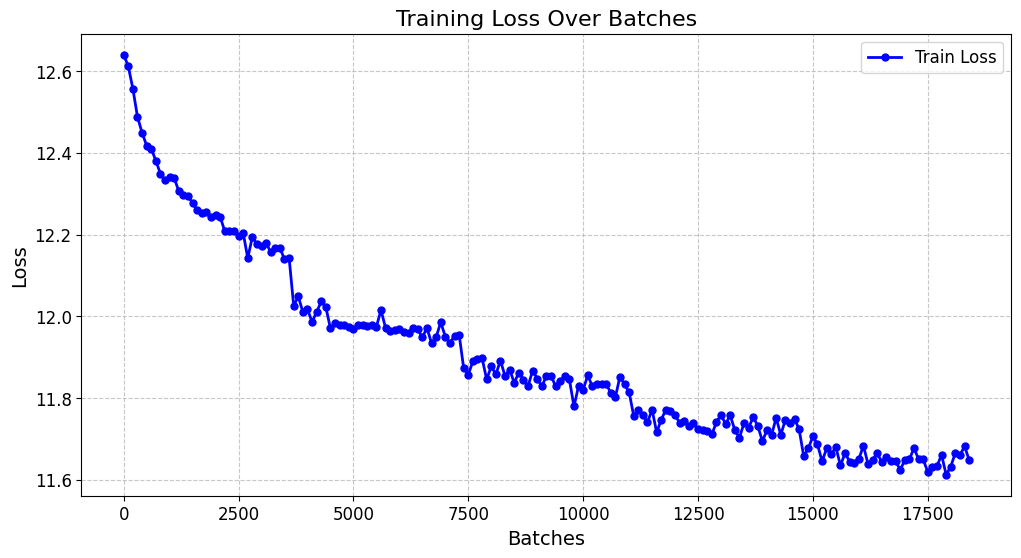

In [18]:
def plot_train_loss(train_losses, log_interval, name='Loss Over Batches'):
    """
    Визуализация train_losses.
    
    :param train_losses: Список значений потерь на тренировке.
    :param log_interval: Интервал логирования (для корректной оси X).
    """
    plt.figure(figsize=(12, 6))
    
    # Ось X: количество батчей
    x = [i * log_interval for i in range(len(train_losses))]
    
    # Отрисовка графика
    plt.plot(x, train_losses, label='Train Loss', marker='o', color='blue', linestyle='-', linewidth=2, markersize=5)
    
    # Настройки графика
    plt.title(name, fontsize=16)
    plt.xlabel('Batches', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Отображение графика
    plt.show()

# Пример использования после обучения
plot_train_loss(train_losses, log_interval=100, name='Training Loss Over Batches')
# plot_train_loss(val_losses_full, log_interval=100, name='Validation Loss Over Batches')

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from tqdm import tqdm
import random

# Дополнительные импорты для работы с изображениями и текстом
from PIL import Image
import requests
from io import BytesIO
import torchvision.transforms as transforms
import torchvision.models as models
from sentence_transformers import SentenceTransformer

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
torch.mps.set_per_process_memory_fraction(0.95)  # Ограничение памяти до 80%
torch.mps.empty_cache()

#########################
# 1. Предобработка метаданных
#########################

def compute_product_meta_features(df, meta_dim=128, device="cpu"):
    """
    Вычисляет мета-вектор для каждого уникального продукта.
    Используются признаки: brand, title, color_base, ktt1 (категория) и изображение из photo_analytics.
    """
    # Инициализируем модель для текстовых эмбеддингов
    text_model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Инициализируем предобученную модель для изображений (удаляем последний классификационный слой)
    image_model = models.resnet18(pretrained=True)
    image_model.fc = nn.Identity()
    image_model = image_model.to(device)
    image_model.eval()  # замораживаем веса для извлечения признаков
    
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    product_meta = {}
    unique_products = df.drop_duplicates(subset=['product_idx'])
    
    for _, row in tqdm(unique_products.iterrows(), desc='Data preparing', total=unique_products.shape[0]):
        product_idx = row['product_idx']
        # Объединяем текстовые признаки
        text_input = f"{row['brand']} {row['title']} {row['color_base']} {row['ktt1']}"
        text_feat = text_model.encode(text_input, convert_to_tensor=True).to(device)
        
        # Извлекаем признаки изображения
        try:
            response = requests.get(row['photo_analytics'], timeout=5)
            image = Image.open(BytesIO(response.content)).convert('RGB')
            image = image_transform(image).unsqueeze(0).to(device)  # переносим на нужное устройство
            with torch.no_grad():
                image_feat = image_model(image).squeeze(0)
        except Exception as e:
            # Если не удалось получить изображение, используем вектор нулей (размер 512)
            image_feat = torch.zeros(512, device=device)
        
        # Конкатенируем текстовые и визуальные признаки
        meta_feat = torch.cat([text_feat, image_feat], dim=0)
        # Если размер полученного вектора не совпадает с meta_dim, применяем линейную проекцию
        if meta_feat.shape[0] != meta_dim:
            proj = nn.Linear(meta_feat.shape[0], meta_dim).to(device)
            meta_feat = proj(meta_feat.unsqueeze(0)).squeeze(0)
        product_meta[product_idx] = meta_feat
    
    return product_meta

# Пример: объединяем train_df и test_df (или используем df_filtered, если он есть)
import pandas as pd
# df_filtered = pd.concat([train_df, test_df], ignore_index=True)  # если необходимо объединить

# Предположим, что у вас уже есть df_filtered с нужными столбцами
product_meta_dict = compute_product_meta_features(df_filtered, meta_dim=128)

# Количество уникальных товаров
num_items = df_filtered['product_idx'].nunique()

# Формируем матрицу весов для мета-эмбеддингов размерности (num_items+2, meta_dim)
# +2 для pad (индекс 0) и mask токена (индекс num_items+1)
meta_dim = 128
meta_weights = torch.zeros(num_items + 2, meta_dim)
# Заполняем веса для индексов от 1 до num_items (предполагается, что product_idx начинается с 1)
for idx in range(1, num_items + 1):
    if idx in product_meta_dict:
        meta_weights[idx] = product_meta_dict[idx]
    else:
        meta_weights[idx] = torch.zeros(meta_dim)
# Для токена 0 (pad) и токена mask (num_items+1) оставляем нули

#########################
# 2. Модификация модели BERT4Rec
#########################

class BERT4RecModel(nn.Module):
    def __init__(self, num_items, max_len, meta_embedding_weights, embedding_dim=512, num_layers=6, num_heads=8, 
                 dropout=0.1, ffn_dim=2048):
        """
        Модель BERT4Rec с дополнительными метаданными продукта.
        
        :param num_items: количество уникальных товаров
        :param max_len: максимальная длина последовательности
        :param meta_embedding_weights: предвычисленная матрица мета-векторов (torch.Tensor) размером (num_items+2, meta_dim)
        :param embedding_dim: размерность эмбеддингов товара
        :param num_layers: количество слоёв трансформера
        :param num_heads: количество голов внимания
        :param dropout: dropout
        :param ffn_dim: размерность FFN
        """
        super().__init__()
        self.num_items = num_items
        self.max_len = max_len
        
        # Эмбеддинги товара (токены: индексы от 0 до num_items+1)
        self.item_embeddings = nn.Embedding(num_items + 2, embedding_dim, padding_idx=0)
        
        # Слой мета-эмбеддингов (инициализируется предвычисленными признаками)
        meta_dim = meta_embedding_weights.shape[1]
        self.meta_embedding = nn.Embedding(num_items + 2, meta_dim, padding_idx=0)
        self.meta_embedding.weight = nn.Parameter(meta_embedding_weights, requires_grad=False)  # замораживаем или можно fine-tune
        # Проекция объединённого представления (конкатенация item и meta признаков)
        self.meta_proj = nn.Linear(embedding_dim + meta_dim, embedding_dim)
        
        # Позиционные эмбеддинги
        self.position_embeddings = nn.Embedding(max_len, embedding_dim)
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)
        
        # Трансформерный энкодер
        encoder_layers = TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=ffn_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Классификационная голова
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 2),
            nn.GELU(),
            nn.LayerNorm(embedding_dim * 2),
            nn.Linear(embedding_dim * 2, num_items + 1)  # +1 так как target начинается с 1
        )
        
        self._init_weights()

    def _init_weights(self):
        # Инициализация эмбеддингов и весов трансформера
        nn.init.normal_(self.item_embeddings.weight, mean=0.0, std=0.02)
        nn.init.normal_(self.position_embeddings.weight, mean=0.0, std=0.02)
        for layer in self.transformer.layers:
            nn.init.xavier_uniform_(layer.self_attn.in_proj_weight)
            nn.init.xavier_uniform_(layer.self_attn.out_proj.weight)
            nn.init.xavier_uniform_(layer.linear1.weight)
            nn.init.xavier_uniform_(layer.linear2.weight)
        nn.init.xavier_uniform_(self.fc[0].weight)
        nn.init.xavier_uniform_(self.fc[3].weight)

    def forward(self, input_ids, attention_mask, position_ids):
        # Эмбеддинги товара
        item_embeds = self.item_embeddings(input_ids)
        # Мета-эмбеддинги (дополнительная информация)
        meta_embeds = self.meta_embedding(input_ids)
        # Объединяем: конкатенируем и проецируем в embedding_dim
        combined_embeds = torch.cat([item_embeds, meta_embeds], dim=-1)
        combined_embeds = self.meta_proj(combined_embeds)
        
        # Позиционные эмбеддинги
        pos_embeds = self.position_embeddings(position_ids)
        
        # Суммируем эмбеддинги и позиционные признаки, применяем LayerNorm и Dropout
        embeddings = self.layer_norm(combined_embeds + pos_embeds)
        embeddings = self.dropout(embeddings)
        
        # Маска для паддингов
        src_key_padding_mask = (attention_mask == 0)
        
        # Пропускаем через трансформер
        transformer_output = self.transformer(embeddings, src_key_padding_mask=src_key_padding_mask)
        
        # Классификационная голова
        logits = self.fc(transformer_output)
        return logits

#########################
# 3. Остальной код обучения остаётся аналогичным
#########################

# Пример создания датасетов, DataLoader и тренировки (код у вас уже есть)
# При этом BERT4RecDataset не меняется, поскольку последовательности остаются на уровне product_idx

# Параметры
max_len = 12          # Максимальная длина последовательности
mask_prob = 0.2       # Вероятность маскирования
batch_size = 64

# Преобразуем словари последовательностей в список кортежей (user_id, sequence)
train_sequences_list = list(train_sequences.items())
test_sequences_list = list(test_sequences.items())

# Создаём датасеты (ваш класс BERT4RecDataset не изменился)
train_dataset = BERT4RecDataset(
    sequences=train_sequences_list,
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=True
)

test_dataset = BERT4RecDataset(
    sequences=test_sequences_list,
    max_len=max_len,
    mask_prob=mask_prob,
    num_items=num_items,
    is_train=False
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

model = BERT4RecModel(
    num_items=num_items,
    max_len=max_len,
    meta_embedding_weights=meta_weights,
    embedding_dim=256,    # например, 256
    num_layers=3,         # количество слоёв
    num_heads=4,          # количество голов
    dropout=0.01
).to(device)

# Настраиваем оптимизатор
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Функция тренировки (ваша, как ранее)
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=5,
    log_interval=50,
    save_path="best_model.pth",
):
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0)
    best_loss = float('inf')
    
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar_train = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Training, Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, batch in progress_bar_train:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            position_ids = batch['position_ids'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, position_ids)
            loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            running_loss += loss.item()
            if (batch_idx + 1) % log_interval == 0:
                avg_loss = running_loss / log_interval
                train_loss_history.append(avg_loss)
                running_loss = 0.0
                progress_bar_train.set_postfix(loss=avg_loss)
        
        # Валидация (если нужно, можно раскомментировать)
        # model.eval()
        # val_loss = 0.0
        # with torch.no_grad():
        #     for batch in val_loader:
        #         input_ids = batch['input_ids'].to(device)
        #         labels = batch['labels'].to(device)
        #         attention_mask = batch['attention_mask'].to(device)
        #         position_ids = batch['position_ids'].to(device)
        #         outputs = model(input_ids, attention_mask, position_ids)
        #         loss = criterion(outputs.view(-1, outputs.size(-1)), labels.view(-1))
        #         val_loss += loss.item()
        # avg_val_loss = val_loss / len(val_loader)
        # val_loss_history.append(avg_val_loss)
        # if avg_val_loss < best_loss:
        #     best_loss = avg_val_loss
        #     torch.save(model.state_dict(), save_path)
        #     print(f"New best model saved with val loss: {best_loss:.4f}")
    
    return train_loss_history, val_loss_history

# Запускаем обучение
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=5,
    log_interval=100,
    save_path="bert4rec_best.pth"
)


Data preparing:   0%|          | 19/309343 [01:21<367:54:27,  4.28s/it]


KeyboardInterrupt: 

In [124]:
# Функция для параллельной генерации рекомендаций (на входе батч из тестового DataLoader)
def generate_parallel_recommendations(model, input_ids, attention_mask, position_ids, k=6, device=device):
    model.eval()
    with torch.no_grad():
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        position_ids = position_ids.to(device)
        
        # Получаем выходы модели: [B, seq_len, num_items+1]
        outputs = model(input_ids, attention_mask, position_ids)
        # Берем логиты последнего токена (последний временной шаг)
        logits = outputs[:, -1, :]  # размер [B, num_items+1]
        # Выбираем топ-k рекомендаций для каждого примера
        recs = torch.topk(logits, k=k, dim=-1).indices
    return recs

# Функция для последовательной генерации рекомендаций для одного пользователя
def generate_sequential_recommendations(model, initial_sequence, max_len, k=6, device=device):
    """
    Генерирует последовательные рекомендации (авторегрессивно) для одного пользователя.
    
    :param initial_sequence: Исходная последовательность (список int) без паддинга.
    :param max_len: Максимальная длина последовательности, с которой обучалась модель.
    :param k: Количество генерируемых рекомендаций.
    :param device: Устройство.
    :return: Список сгенерированных рекомендаций.
    """
    model.eval()
    generated = []
    current_seq = initial_sequence.copy()
    
    with torch.no_grad():
        for _ in range(k):
            # Если длина последовательности меньше max_len – дополняем слева паддингом (значение 0)
            if len(current_seq) < max_len:
                padded_seq = [0] * (max_len - len(current_seq)) + current_seq
            else:
                padded_seq = current_seq[-max_len:]
            
            input_ids = torch.tensor(padded_seq, dtype=torch.long, device=device).unsqueeze(0)
            attention_mask = (input_ids != 0).long()
            position_ids = torch.arange(max_len, dtype=torch.long, device=device).unsqueeze(0)
            
            outputs = model(input_ids, attention_mask, position_ids)  # [1, max_len, num_items+1]
            logits = outputs[:, -1, :]  # [1, num_items+1]
            next_token = torch.topk(logits, k=1, dim=-1).indices.squeeze().item()
            generated.append(next_token)
            current_seq.append(next_token)
    
    return generated

In [125]:
def run_parallel_inference(model, inference_loader, k=6, device=device):
    """
    Запускает инференс на inference_loader и получает топ-K рекомендаций для каждого пользователя.
    
    :param model: Обученная модель BERT4Rec
    :param inference_loader: DataLoader без маскированных токенов (данные из train)
    :param k: Количество рекомендаций
    :param device: Устройство (CPU/GPU)
    :return: Список предсказанных рекомендаций для всех пользователей
    """
    model.eval()
    all_recommendations = []

    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Parallel Inference"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            position_ids = batch["position_ids"].to(device)

            # Генерируем k рекомендаций
            recs = generate_parallel_recommendations(model, input_ids, attention_mask, position_ids, k=k, device=device)
            
            all_recommendations.extend(recs.cpu().tolist())

    return all_recommendations


def run_sequential_inference(model, inference_loader, max_len, k=6, device=device):
    """
    Запускает последовательный инференс: для каждого пользователя из inference_loader извлекается исходная (непадённая) последовательность,
    и генерируется последовательность рекомендаций методом авторегрессии.
    
    :param model: Обученная модель BERT4Rec.
    :param inference_loader: DataLoader с данными (is_train=False).
    :param max_len: Максимальная длина последовательности.
    :param k: Количество генерируемых рекомендаций для каждого пользователя.
    :param device: Устройство.
    :return: Словарь вида {user_id: [последовательность рекомендаций]}.
    """
    model.eval()
    user_recs = {}
    
    with torch.no_grad():
        for batch in tqdm(inference_loader, desc="Sequential Inference"):
            input_ids = batch['input_ids']           # [B, max_len]
            attention_mask = batch['attention_mask']   # [B, max_len]
            user_ids = batch['user_id']                # список user_id
            
            # Для каждого пользователя в батче извлекаем исходную последовательность без паддинга
            for i in range(input_ids.shape[0]):
                # Переходим на CPU, чтобы легко работать со списками
                seq = input_ids[i].cpu().tolist()
                mask = attention_mask[i].cpu().tolist()
                # Извлекаем только те токены, где mask==1 (непаддинговые элементы)
                initial_seq = [token for token, m in zip(seq, mask) if m == 1]
                recs = generate_sequential_recommendations(model, initial_seq, max_len, k=k, device=device)
                user_recs[user_ids[i]] = recs

    return user_recs

In [96]:
# Используем train-данные для генерации предсказаний
inference_dataset = BERT4RecDataset(sequences=train_sequences_list, max_len=max_len, mask_prob=0.0, num_items=num_items, is_train=False)
inference_loader = DataLoader(inference_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def map_recommendations_to_users(user_ids, recommendations):
    """
    Преобразует список рекомендаций в словарь {user_id: recommendations}.

    :param user_ids: Список ID пользователей из inference_loader
    :param recommendations: Список рекомендаций из parallel_recs
    :return: Словарь {user_id: [recommendations]}
    """
    user_to_recs = {user: recs for user, recs in zip(user_ids, recommendations)}
    return user_to_recs

# Получаем список пользователей из inference_loader
user_ids = inference_loader.dataset.user_ids

In [ ]:
# Параллельные предсказания (Batch Inference)
parallel_recs = run_parallel_inference(model, inference_loader, k=k, device=device)

# Создаём словарь {user_id: recommendations}
test_user_to_parallel_recs = map_recommendations_to_users(user_ids, parallel_recs)

In [ ]:
# Последовательные предсказания (Sequential Inference)
sequential_recs = run_sequential_inference(model, inference_loader, max_len=max_len, k=k, device=device)

# Создаём словарь {user_id: recommendations}
test_user_to_sequential_recs = map_recommendations_to_users(user_ids, sequential_recs)

Sequential Inference:   0%|          | 0/8541 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [110]:
dataset_bert4rec_classic_parallel = RecommendationDataset(user_recommendations=test_user_to_parallel_recs, user_to_true_items=test_user_to_true_items, k=k)
loader = DataLoader(dataset_bert4rec_classic_parallel, batch_size=batch_size, collate_fn=collate_fn, num_workers=0)

In [112]:
precision_k = precision_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Precision@k: {precision_k:.5f}')

recall_k = recall_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'Recall@k: {recall_k:5f}')

map_k = map_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'MAP@k: {map_k:.5f}')

ndcg_k = ndcg_at_k_gpu(loader=loader, k=k, batch_size=batch_size)
print(f'NDCG@k: {ndcg_k:.5f}')

Precision@K:   0%|          | 0/8541 [00:00<?, ?it/s]

Precision@k: 0.00379


Recall@K:   0%|          | 0/8541 [00:00<?, ?it/s]

Recall@k: 0.003697


MAP@K:   0%|          | 0/8541 [00:00<?, ?it/s]

MAP@k: 0.00156


NDCG@K:   0%|          | 0/8541 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
log_model_results(model_name='Top-K', k=k, precision_k=precision_k, recall_k=recall_k, map_k=map_k, ndcg_k=ndcg_k, hyperparameters=None)
df_metrics

In [25]:
import gc
import weakref

for obj in gc.get_objects():
    try:
        if isinstance(obj, torch.Tensor) and obj.is_mps:
            ref = weakref.ref(obj)
            del obj
            del ref
    except ReferenceError:
        pass

gc.collect()
torch.mps.empty_cache()

### BERT4Rec Git version
https://github.com/asash/bert4rec_repro